
# NOTE: INSTALL PACKAGES IN CELL BELOW
<span style="color:red;font-size:250%"># NOTE: INSTALL PACKAGES IN CELL BELOW</span>


In [1]:
!pip install plotnine duckdb jax numpyro pyarrow graphviz --quiet

## Other important code-related details!

1. The (full) primary dataset is far too large to be submitted with the project. Even compressed it is >10gb and tens of millions of rows long. 
    1. All _linked_ datasets are included directly, and are what is used for the analysis. They are loaded in the really big code chunk two chunks from now. I also included some extras you are free to comment / uncomment if you wish. 
    2. I included the SQL code I used to link and transform the data into a usable form in both a .sql file as well as in a cell in the notebook. None of this will be actually run, though, without the main dataset. I had to use SQL (in particular, duckdb) as it was not even remotely close to fitting into memory otherwise. 
    3. All graphs will be loaded from a separate chain .nc file before analysis. I will have a commented out section that will assign them directly from this notebook if you wish. I did this because I ended up having to train it separately (using a GPU) for it to not to take forever, and so saved the chains before doing any analysis locally myself! I hope this is okay. I know you have a workstation, and it may run for you, but just as a warning some of them took hours even running on an A100... 
    4. It should still run if you aren't using a GPU, whatever JAX ends up using. It might still work if using the base sampler but I am fairly sure JAX would be faster either way because it's JIT compiled. The particular sampler is from numpyro. I will add commented out base sampler versions in every model, though. 
    5. All important figures are saved in a distinct /Figures directory. My jupyter would straight up crash trying to load them if I didn't do this. I don't know if there is a work around for this or if this is just the consequence of working with large moddels like this

In [2]:
import pandas as pd
import numpy as np
import seaborn.objects as so
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb as db
import numpyro
import jax
import arviz as az
import pyarrow
import scipy.spatial
import pymc as pm 
import matplotlib as mpl
import pymc.sampling_jax as pm_jax
import statsmodels.formula.api as smf
import statsmodels as sm
from statsmodels.iolib.summary2 import summary_col
import os
from IPython.display import display, Markdown, Latex
def dmd(text):
    display(Markdown(text))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
os.chdir("/content/drive/MyDrive/colab/final/")

plt.rcParams["figure.autolayout"] = True
az.rcParams['plot.max_subplots'] = 200


az.style.use("arviz-doc")

In [35]:
# Datasets and model loading
## combined is the dataset I used for the analysis, cut down to only linked sampled 
## one_pct is a one percent sample of the 1870 and 1910 census randomly sampled 
## from a duckdb database of the full census
## Did not include as full sample is way too large to submit. I can provide it over google drive or something if you want. 
combined = pd.read_parquet("comb_1870_1910.parquet")
one_pct = pd.read_parquet('ipums_cleaned_sample_onepct.parquet')

# I am only loading the 10% datasets. No models run by default, but I will have these loaded in case. 
comb_1870_1910_std_full_10pct = pd.read_parquet('comb_1870_1910_std_full_10pct.parquet')
comb_1870_1910_conservative_full_10pct = pd.read_parquet('comb_1870_1910_conservative_full_10pct.parquet')
state_dist_dataset_special = pd.read_parquet('comb_1870_1910_conservative_full_10pct_state_dist.parquet')

## ALL OF THESE ARE DISABLED! If you want to try and run the _FULL_ model on your machine, you can uncomment these and run them.

#comb_1870_1910_std_full_25pct = pd.read_parquet('comb_1870_1910_std_full_25pct.parquet')
#comb_1870_1910_std_full = pd.read_parquet('comb_1870_1910_std_full.parquet')
#comb_1870_1910_conservative_full_25pct = pd.read_parquet('comb_1870_1910_conservative_full_25pct.parquet')
#comb_1870_1910_conservative_full = pd.read_parquet('comb_1870_1910_conservative_full.parquet')
state_idx_to_state = pd.read_csv('icp_conversion.csv')

# Loading Traces from external files 

edu_race_std_full_trace = az.from_netcdf('Models/edu_race_std_full.nc')
ln_wages_conservative_full = az.from_netcdf('Models/ln_wages_conservative_full.nc')
ln_wages_conservative_25pct = az.from_netcdf('Models/ln_wages_1870_conservative_25pct.nc')
ln_wages_std_25pct = az.from_netcdf('Models/ln_wages_1870_std_25pct.nc')
ln_wages_age_conservative_10pct = az.from_netcdf('Models/ln_wages_age_conservative_10pct.nc')
ln_wages_state_change_conservative_10pct = az.from_netcdf('Models/ln_wages_state_change_conservative_10pct.nc')
ln_wages_state_change_std_full = az.from_netcdf('Models/ln_wages_state_change_std_full.nc')
ln_wage_state_dist_conservative_10pct = az.from_netcdf('Models/state_dist_alone_basic_conservative_10pct.nc')
ln_wage_state_dist_race_conservative_10pct = az.from_netcdf('Models/state_dist_race_conservative_10pct.nc')

state_lst_raw = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'Delaware', 'New Jersey', 'New York', 'Pennsylvania', 'Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota', 'Virginia', 'Alabama', 'Arkansas', 'Florida', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Texas', 'Kentucky', 'Maryland', 'Tennessee', 'West Virginia', 'Colorado', 'Nevada', 'New Mexico', 'Utah', 'California', 'Oregon', 'Washington', 'District of Columbia']
state_lst = ['Connecticut (0)', 'Maine (1)', 'Massachusetts (2)', 'New Hampshire (3)', 'Rhode Island (4)', 'Vermont (5)', 'Delaware (6)', 'New Jersey (7)', 'New York (8)', 'Pennsylvania (9)', 'Illinois (10)', 'Indiana (11)', 'Michigan (12)', 'Ohio (13)', 'Wisconsin (14)', 'Iowa (15)', 'Kansas (16)', 'Minnesota (17)', 'Missouri (18)', 'Nebraska (19)', 'North Dakota (20)', 'South Dakota (21)', 'Virginia (22)', 'Alabama (23)', 'Arkansas (24)', 'Florida (25)', 'Georgia (26)', 'Louisiana (27)', 'Mississippi (28)', 'North Carolina (29)', 'South Carolina (30)', 'Texas (31)', 'Kentucky (32)', 'Maryland (33)', 'Tennessee (34)', 'West Virginia (35)', 'Colorado (36)', 'Nevada (37)', 'New Mexico (38)', 'Utah (39)', 'California (40)', 'Oregon (41)', 'Washington (42)', 'District of Columbia (43)']
def fix_chain_axis(chain, num):
    for i in range(num):
        chain.posterior.coords[F"beta_{i}_dim_0"] = state_lst
[
    fix_chain_axis(chain, num) for chain, num in zip([edu_race_std_full_trace, ln_wages_conservative_full, \
                                                        ln_wages_conservative_25pct, ln_wages_std_25pct, \
                                                        ln_wages_age_conservative_10pct, ln_wages_state_change_conservative_10pct, \
                                                        ln_wages_state_change_std_full, ln_wage_state_dist_conservative_10pct, ln_wage_state_dist_race_conservative_10pct], [2, 2, 2, 2, 4, 4, 4,2,4])
                                                     
]

[None, None, None, None, None, None, None, None, None]

In [ ]:
# DONT RUN (Unneccessary)

statesDF = pd.read_csv('states.csv');

# create distances dataframe
distancesDF = pd.DataFrame(columns=["state1", "state2", "distance"])

for state1, lat1, lon1 in zip(statesDF.state, statesDF.latitude, statesDF.longitude):
    for state2, lat2, lon2 in zip(statesDF.state, statesDF.latitude, statesDF.longitude):
        distancesDF = distancesDF.append({
            "state1": state1,
            "state2": state2,
            "distance": scipy.spatial.distance.euclidean([float(lat1), float(lon1)], [float(lat2), float(lon2)])
            }, ignore_index=True);

distancesDF.to_csv('state_distances.csv', index=False);
distancesDF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/Users/liz/Documents/Projects/ECON_414/Final_Presentation'

<h1>Introduction</h1>
<p>The late 19th to early 20th century was one of (if not the) fastest changing periods in American history. We moved from an agrarian society just exiting the civil war to a modern industrialized nation. This was a period of massive change, and it is important to understand how this change affected the people living through it. There are many possible ways to quantify this, and many have been done. You can look at the problem anecdotally, try and examine large scale population statistics of various economic variables, but I think the most interesting way to look at it is through the lens of individual people and geography.</p>
<p>With the rise of automated census linking techniques, we have very rich <em>person level</em> digitized census records from the time period. Roughly one per American alive at the time. This is an incredible resource, and has been used to answer many questions. The question of interest today, however, is economic change <em>within</em> someone’s lifetime. This is achieved by use of the census linking project, a project using automated tooling to link specific individuals across census years. This allows for a view into the life trajectory of individual people, not just aggregate statistics. This is frequently used to estimate things such as intergenerational mobility and other bigger picture questions, but I think it’s missing something: geography.</p>
<p>In a world where we have a data point for each American alive during the entire time period, we can look at the smaller, intra-person level changes. I want to focus in on a few key items for this paper. The first is the general backdrop grouped by geography and other relevant variables, namely race. The second incorporates the fact that we have <em>two</em> time periods, and therefore people have moved. I want to look at how this movement affects the trajectory of people’s lives, and if this differes by regions or racial groups. The third is to integrate the actual geographic data itself into the model in the form of a birds eye distance between origin and destination states, and see if the distance itself has a large effect.</p>
<h1>Literature Review</h1>
<p>A literature review can take this on from two primary angles: the technical side (primarily census linking) and focusing on the specific topic of interest. I will start with the first with the source of this linking: Census Linking Project <span class="citation" data-cites="abramitzky.etal22">(<a href="#ref-abramitzky.etal22" role="doc-biblioref">Abramitzky et al. 2022</a>)</span>. There have been several previous attempts to achieve this linking, and they can be tested in a few key ways. One of the more novel methods of crowd sourcing validation is family tree websites, where users have a personal family investment in mapping their own heritage. This data, combined with some special much more accurate data from former Union soliders, formed the benchmark. The linking process itself also was trained on data combining two different digitizations of the same census, helping name mismattches from spelling differences. As someone who has digitized these records before, this is extremely common. The metholodgy behind this linking is complicated, but the method this paper uses NYSIIS name standardization, which is a common dataset of name spelling to help counteract spelling errors and make more accurate links. Generally, linking algorithms and human matching agree in around 90% of cases <span class="citation" data-cites="abramitzky.etal21">(<a href="#ref-abramitzky.etal21" role="doc-biblioref">Abramitzky et al. 2021</a>)</span>.</p>
<p>On a slightly less technical note, there are many other papers using these linked census records. One of the more interesting (and relevant!) one’s I read was <span class="citation" data-cites="dupont.rosenbloom18">Dupont and Rosenbloom (<a href="#ref-dupont.rosenbloom18" role="doc-biblioref">2018</a>)</span>. The paper deals with a similar time period to this one, the 1860s to be specific, just after the civil war caused a huge economic upset in the region. This caused huge economic upset in the region, but also lead to higher economic mobility more generally, even compared to the north. Despite this, it still wasn’t especially mobile, with large amounts of wealth persistence. They were able to calculate this upset because of the innovations in census linking allowing them to track the most wealthy individuals between the 1860 and 1870 census, something not possible until relatively recently. This connects especially well to this paper because of it’s emphasis and use of regional variation between the north and south.</p>
<p><span class="citation" data-cites="collins.wanamaker14">Collins and Wanamaker (<a href="#ref-collins.wanamaker14" role="doc-biblioref">2014</a>)</span> is another paper that uses the census linking project to reach novel conclusions, and is directly connected to geography. It’s primary aim is to capture the effect of the great migration on income, racial economic gaps, mobility, etc. Essentially, using the 1910 to 1930 census and it’s geographic elements to attempt to estimate the effects of the great migration on the <em>individual people</em> who actually migrated. This level of detail is fascinating, especially with something as pivotal to greater American history as the great migration. It was often previously theorized the great migration’s benefits were often mostly due to selection effects, or at least majorly so. <span class="citation" data-cites="collins.wanamaker14">Collins and Wanamaker (<a href="#ref-collins.wanamaker14" role="doc-biblioref">2014</a>)</span>, however, showed quite a lot of evidence to the contrary, with it being very widespread across rural and urban origins, literate and illiterate, and various occupations. In the end, they find that the great migration was a key force in the black-white convergence in economic status during the time period. It is truly incredible how much deep insight can be gained from this data, and how much it can change our understanding of history.</p>
<p>While <span class="citation" data-cites="collins.wanamaker14">Collins and Wanamaker (<a href="#ref-collins.wanamaker14" role="doc-biblioref">2014</a>)</span> also focused heavily on economic mobility, it is expored in much greater detail in <span class="citation" data-cites="olivetti.paserman15">Olivetti and Paserman (<a href="#ref-olivetti.paserman15" role="doc-biblioref">2015</a>)</span>. They also use linked census records, but this time with a very specific focus on estimating specific intergenerational income elasticities. This is typically done by matching the census record of fathers and sons, as shared last names (traditionally) make it far easier to link. Instead, they use a first name pseudo-linking system to help estimate the distributed intergenerational effect across both siblings. The paper is more than I can get into right now, but it is a very interesting read and is quite creative.</p>
<p>Another interesting paper to use similar methods is <span class="citation" data-cites="baker.etal20">Baker, Blanchette, and Eriksson (<a href="#ref-baker.etal20" role="doc-biblioref">2020</a>)</span>. While it’s more of a natural experiment than anything else, it uses these same datasets in a really novel way. The paper used the ‘boll weevil’, a devastating pest that destroyed cotton crops in the south, as a natural experiment to measure the effects of agricultural shocks on education. They used the linked census records to link back individuals from the time of the pest back to their childhood census records. This allowed the boll weevil to be used successfully as a natural experiment that would have been impossible otherwise. In the end, they found that being the right age when the weevil arrived increased educational attainment by .24 to .36 years.</p>
<p>The final paper in this literature review is <span class="citation" data-cites="collins.zimran19">Collins and Zimran (<a href="#ref-collins.zimran19" role="doc-biblioref">2019</a>)</span>, who uses a the wave of Irish immigrants entering the US from the potato famine to build a dataset showing the assimilation of migrants over time using linked census data. They find that there is a very significant penalty to new immigrants when first entering the country thath persists across generations, but that said gap converges over time, with their sons experiencing a much smaller gap. This is a very interesting paper, and also deals with census data in the context of geographic heterogeneity. Overall, I think this literature review shows a lot to be desired. I think the problem is that most of these papers have something additional or a secondary niche that they are using this dataset to explore the effects of, which in retrospect would have been a more interesting paper. Nevertheless, I think it demonstrates the usefulness of this dataset, especially within the context of geographic mobility.</p>


# Data

## Data Sources

All data for this project came from two full count decennial census records. The first came from 1860, and the second came from 1920. I picked these years because they are close enough apart to reasonably have adults alive in one census still be alive in the later census, but far enough apart to really grasp longer term life trajectories over one of the fastest changing times in American history. These datasets are full count population level census records, and were accessed through IPUMS USA. The other dataset used was from the Census Linking Project. This is key to the project, as it uses an automated matching procedure to match individuals across time. Without this, we could not measure within-individual change. 


## Practical problems 

This dataset in its raw form is quite big, over 10gb in size while compressed (30+ otherwise), and is >100M rows long. This would most definitely not fit in memory, which caused significant issues. In fact, all figures generated here are using a 1% sample, which is still over a million rows long! Thankfully, the number of linked samples is comparatively less, being somewhere between a million and two million rows long depending on which linking method is used. This is still quite large, but is at least manageable. When loading the data itself, I had to use duckdb. Duckdb is designed for OLAP column-store queries, and doesn't require it to be in memory. I used this to do almost all of the data processing, and then saved it to a parquet file.

I will attatch the literal .sql file I wrote it in as well as paste it in the cell below. It should be commented significantly. This will not actually run it, though, as I typically either read the .sql file into memory and used `con.sql()` to run it as a long string, or just directly used the duckdb cli. I'll include the code to read it in as well, but won't really be useful to you unless you want me to send you the full database (22+GB). The SQL cell below is just markdown with SQL syntax highlighting. 



```sql
-- This is just a little table I used to deal with keeping track of the 
-- Indexes of the states in the ICP data across the tables. 
-- Relies on a csv file called icp_conversion.csv that I created from the
-- ICP code conversion chart online.
create or replace table icp_state_conversion(
    idx integer primary key,
    state varchar,
    stateicp integer
);
COPY icp_state_conversion from 'icp_conversion.csv' (AUTO_DETECT TRUE);

-- Copies the data I need off the full dataset
-- Just doing this as I don't use a significant portion of the data
-- that I got from IPUMS.
create or replace view ipums_cleaned as (
    select 
    year, 
    histid, 
    sex,
    age,
    race,
    icp.state as state,
    icp.idx as state_idx,
    ipums_second.stateicp as stateicp,
    -- If not white then 1 else 0 
    case when 
    race != 1 then 1 
    else 0
    end as not_white,
    case when 
    lit = 0 or lit = 1 then 0
    else 1
    end as lit,
    school,
    occ1950,
    occscore,
    -- Signals missing vals
    case when edscor50 = 9999 then 1
    when edscor50 = 999.9 then 1 else 0 end as edscor50_missing,
    -- Replaces missing vals with zero
    case when edscor50_missing == 1 then 0 else edscor50 end as edscor50,

    case when occscore = 0 then 0
    else ln(occscore) end as log_earnings
    from ipums_second left join icp_state_conversion icp 
    on ipums_second.stateicp = icp.stateicp
    where year = 1870 or year = 1910
);


-- Loads in Census Linking Project data as a table

create table if not exists linking_1870_1910 as (
    select 
    * 
    from read_csv_auto("census_linking_proj/1870_1910/crosswalk_1870_1910.csv")
);


create table if not exists state_dist as (
    select 
    * 
    from read_csv_auto("state_distances.csv")
);

-- Creates a view that has the 1870 and 1910 data joined together

CREATE
OR REPLACE VIEW mixed_1870_1910 AS (
    SELECT
        c1870.year AS c1870_year,
        c1870.histid AS c1870_histid,
        -- Mostly redundant, ended up using conservative match
        -- For a lot of the models anyways. 
        case when lk.abe_nysiis_conservative == 1 then 1 else 0 end as conservative_match,
        c1870.stateicp AS c1870_stateicp,
        c1870.state as c1870_state,
        c1870.state_idx as c1870_state_idx,
        c1870.sex AS c1870_sex,
        c1870.age AS c1870_age,
        c1870.race AS c1870_race,
        c1870.not_white AS c1870_not_white,
        c1870.lit AS c1870_lit,
        c1870.school AS c1870_school,
        c1870.occ1950 AS c1870_occ1950,
        c1870.occscore AS c1870_occscore,
        c1870.log_earnings AS c1870_log_earnings,
        c1870.edscor50 AS c1870_edscor50,
        c1870.edscor50_missing as c1870_edscor50_missing,
        c1910.year AS c1910_year,
        c1910.histid AS c1910_histid,
        c1910.stateicp AS c1910_stateicp,
        c1910.state as c1910_state,
        c1910.state_idx as c1910_state_idx,
        c1910.sex AS c1910_sex,
        c1910.age AS c1910_age,
        c1910.race AS c1910_race,
        c1910.not_white AS c1910_not_white,
        c1910.lit AS c1910_lit,
        c1910.school AS c1910_school,
        c1910.occ1950 AS c1910_occ1950,
        c1910.occscore AS c1910_occscore,
        c1910.log_earnings AS c1910_log_earnings,
        c1910.edscor50 AS c1910_edscor50,
        c1910.edscor50_missing as c1910_edscor50_missing,

    -- Joins on census linking project data
    FROM linking_1870_1910 lk 
    LEFT JOIN ipums_cleaned c1870
        ON lk.histid_1870 = c1870.histid 
    LEFT JOIN ipums_cleaned c1910
        ON lk.histid_1910 = c1910.histid
    WHERE
        c1870.year = 1870
        AND c1910.year = 1910
    --     AND c1870.year = 1880
        AND lk.abe_nysiis_conservative = 1
        and c1870.state_idx is not null
        and c1910.state_idx is not null
);


create or replace table comb_1870_1910 as (

with a as (
    select 
    case when c1870_not_white == 1 then 
        case 
            when c1910_not_white == 1 then 1
            else c1870_not_white
        end
        else 
            case 
                when c1910_not_white == 0 then c1870_not_white
                else 1
            end 
        end as not_white,
        case 
            when c1870_state == c1910_state then 0
            else 1
        end as state_changed,
        c1870_state as origin_state,
        c1910_state as destination_state,
        c1870_state_idx as origin_state_idx,
        c1910_state_idx as destination_state_idx,
        c1910_lit - c1870_lit as lit_change,
        c1910_school - c1870_school as school_change,
        c1910_log_earnings - c1870_log_earnings as log_earnings_change,
        c1910_occscore - c1870_occscore as occscore_change,
        c1910_edscor50 - c1870_edscor50 as edscor50_change,
        * EXCLUDE (c1870_not_white, c1910_not_white, c1870_state, c1910_state, c1870_state_idx, c1910_state_idx)

    from mixed_1870_1910 

)

SELECT
    -- Had some encoding issues, so hard coded the dtypes
    not_white::BOOLEAN as not_white,
    state_changed::BOOLEAN as state_changed,
    conservative_match::BOOLEAN as conservative_match,
    origin_state,
    destination_state,
    origin_state_idx::INTEGER - 1 as origin_state_idx,
    destination_state_idx::INTEGER - 1 as destination_state_idx,
    lit_change,
    school_change,
    log_earnings_change,
    occscore_change,
    edscor50_change,
    c1870_lit,
    c1870_school,
    c1870_age,
    c1870_occscore,
    c1870_log_earnings,
    c1870_edscor50,
    c1910_lit,
    c1910_school,
    c1910_age,
    c1910_occscore,
    c1910_log_earnings,
    c1910_edscor50


FROM a

);
create table if not exists comb_1870_1910_state_dist as (
    select 
    c.*,
    s.distance as state_dist
    from comb_1870_1910 c left join state_dist s
    on c.origin_state = s.state1 and c.destination_state = s.state2
);

select * from comb_1870_1910 limit 100;


-- I use this parquet file to load the 'combined' variable in the main analysis

-- Standard Linking 

COPY (select * from comb_1870_1910) to 'comb_1870_1910_std_full.parquet' (FORMAT 'parquet');
COPY (
    select * from comb_1870_1910 USING SAMPLE 10 PERCENT (bernoulli)
) to 'comb_1870_1910_std_full_10pct.parquet' (FORMAT 'parquet');
COPY (
    select * from comb_1870_1910 USING SAMPLE 25 PERCENT (bernoulli)
) to 'comb_1870_1910_std_full_25pct.parquet' (FORMAT 'parquet');

-- Conservative Linking 

COPY (
    select * from comb_1870_1910 where conservative_match == TRUE 
) to 'comb_1870_1910_conservative_full.parquet' (FORMAT 'parquet');
COPY (
    select * from comb_1870_1910 where conservative_match == TRUE USING SAMPLE 10 PERCENT (bernoulli)
) to 'comb_1870_1910_conservative_full_10pct.parquet' (FORMAT 'parquet');
COPY (
    select * from comb_1870_1910 where conservative_match == TRUE USING SAMPLE 25 PERCENT (bernoulli)
) to 'comb_1870_1910_conservative_full_25pct.parquet' (FORMAT 'parquet');

COPY (
    select * from comb_1870_1910_state_dist where conservative_match == TRUE USING SAMPLE 10 PERCENT (bernoulli)
) to 'comb_1870_1910_conservative_full_10pct_state_dist.parquet' (FORMAT 'parquet');
-- Used this to generate the one_pct variable used in the analysis  
--COPY (select * from ipums_cleaned USING SAMPLE 1 PERCENT (bernoulli)) to 'ipums_cleaned_sample.parquet' (FORMAT 'parquet');

```

In [ ]:
# read query.sql and execute it
def run_query_dot_sql():
    con = db.connect("project.db")
    con.begin()
    with open('query.sql', 'r') as file:
        query = file.read()

    con.execute(query).df()

    con.commit()

# If you want to load it just run this function (assuming you have the db)


 

## Variable encodings

When processing some of the datasets, I had to make decisions regarding how I would encoding the different variables for processing. You can see the details of this in the SQL code, but I will summarize them here.
The primary variable of interest here is earnings over time, estimated with a 1950 OCCSCORE income estimate. The second of these is the edscor50 variable, representing the chance of having at least one year of college education. Both of these are fundamentally based on occupational categories, and both have a significant number of missing variables.

### OCCSCORE

For each individual year, I logged the income variables, swapping log(0) for 0 so it didn't cause -inf issues. I ended up leaving in the zero values as having no income, but this may not entirely be true and could inflate the numbers somewhat. I have the breakdown attached in the tables below. While there is a _very_ large number of people with zero entries, this seems to be the case for both years. More importantly, when looking at specifically the years of _linked_ data, people who had zero in 1870 were actually less likely to have it for 1910. This is really interesting, but on later inspection, this seems to be a product of age more than anything else, as in the regressions in the cells below controlling for age inverses the effect. I still decided to leave it in, however, as that probably means it simply represents younger people being mostly matched in 1860 (ie, still alive 40yrs later) and would be important. For the actual model itself, I took the difference of the log occscore between the two years. You can see the distribution of the occscores between the years (for the linked group) in the plot below. 






In [4]:
print('Overall Breakdown')
one_pct['occscore_0_pct'] = (one_pct['OCCSCORE'] == 0)*100
one_pct['occscore_0'] = (one_pct['OCCSCORE'] == 0)
one_pct[['YEAR', 'not_white', 'OCCSCORE', 'occscore_0']].groupby(['YEAR', 'not_white']).agg(['mean']).reset_index()

print('Mean occscores by if they were 0 in 1870')
combined['c1870_occscore_0'] = (combined['c1870_occscore'] == 0)
combined['c1910_occscore_0'] = (combined['c1910_occscore'] == 0)
combined[['c1870_occscore', 'c1910_occscore', 'c1870_occscore_0', 'c1910_occscore_0']].groupby(['c1870_occscore_0']).agg(['mean'])


Overall Breakdown


,YEAR,not_white,OCCSCORE,occscore_0
,,,mean,mean
0,1870,0,5.726321,0.691959
1,1870,1,5.055054,0.569423
2,1910,0,8.395745,0.606762
3,1910,1,6.920044,0.474515


Mean occscores by if they were 0 in 1870


,c1870_occscore,c1910_occscore,c1910_occscore_0
,mean,mean,mean
c1870_occscore_0,,,
False,17.372599,15.540056,0.276062
True,0.000000,22.031545,0.078447


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


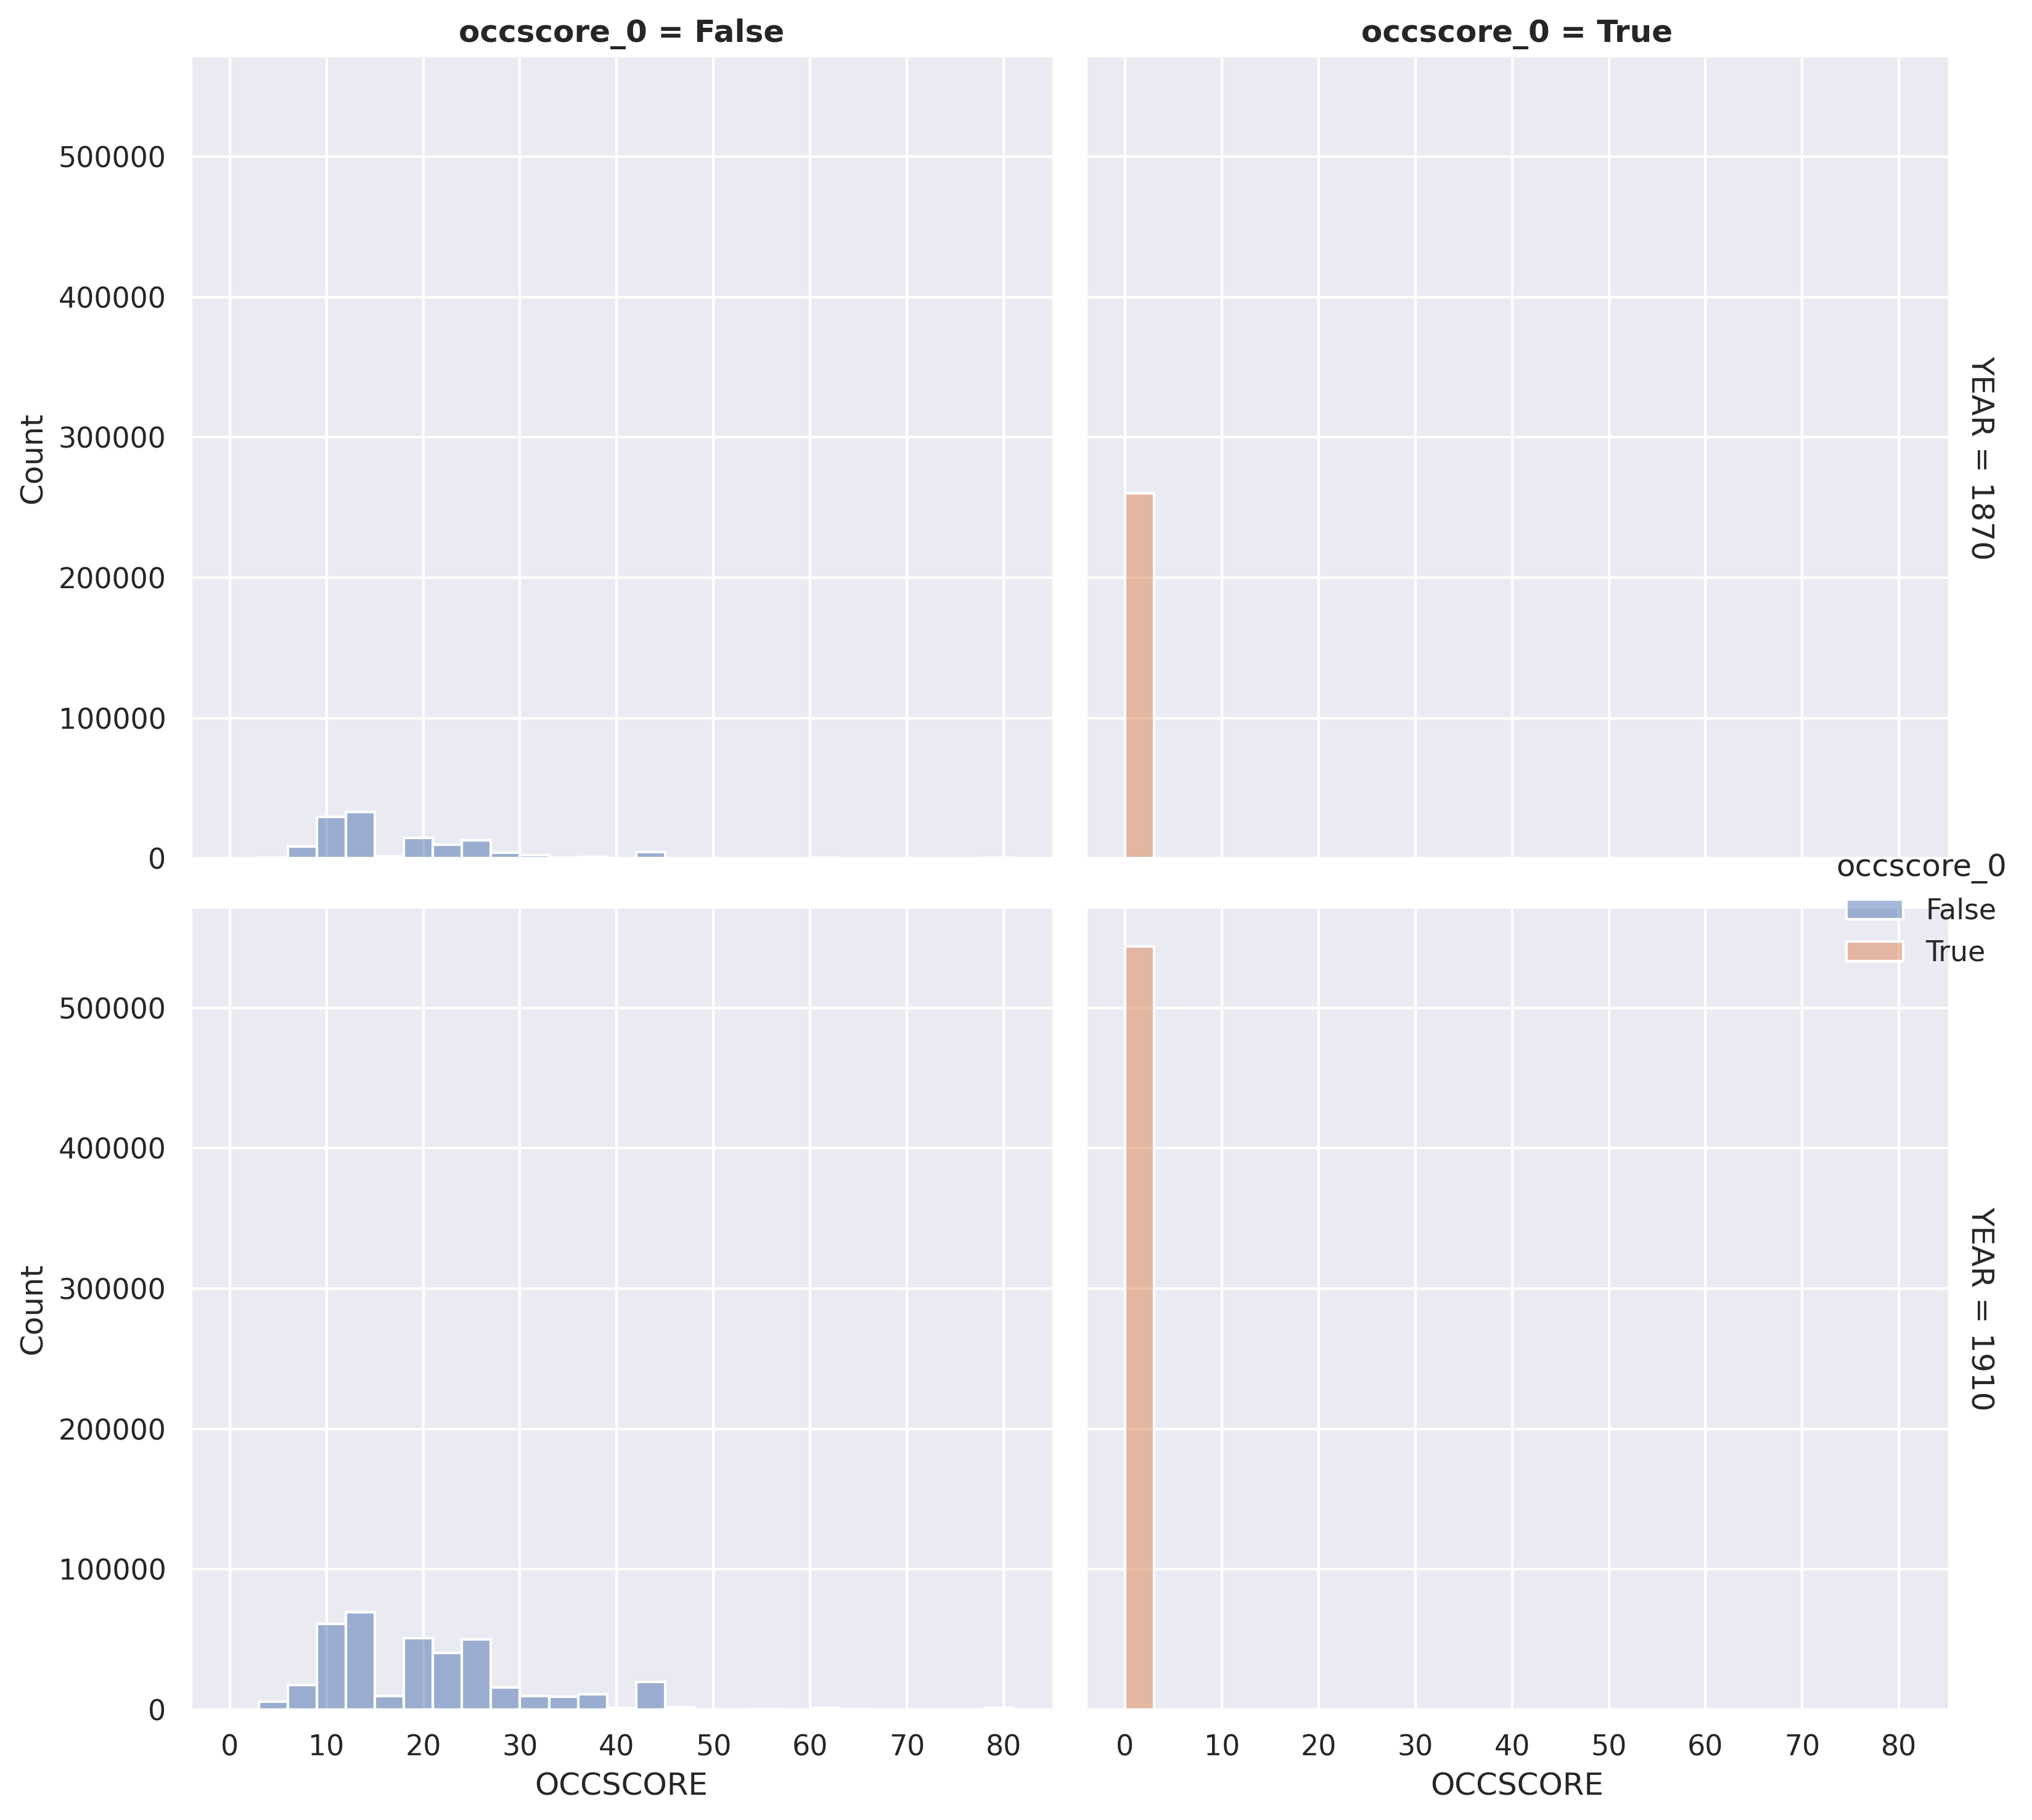

In [7]:
# Hisogram (non linked)
sns.set_theme(style="darkgrid")
sns.displot(
    one_pct, x="OCCSCORE", row="YEAR", col="occscore_0", hue = 'occscore_0',
    binwidth=3,  facet_kws=dict(margin_titles=True),
)

In [6]:
forreg = combined[['c1870_occscore', 'c1910_occscore', 'c1870_occscore_0', 'c1910_occscore_0', 'c1870_age']]
forreg['age_squared'] = forreg['c1870_age']**2
forreg[['c1870_occscore_0', 'c1910_occscore_0']] = forreg[['c1870_occscore_0', 'c1910_occscore_0']].astype(int)

<ipython-input-6-a2528cfad297>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forreg['age_squared'] = forreg['c1870_age']**2
<ipython-input-6-a2528cfad297>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forreg[['c1870_occscore_0', 'c1910_occscore_0']] = forreg[['c1870_occscore_0', 'c1910_occscore_0']].astype(int)


#### Unlinked:

,OCCSCORE
Intercept,-4.1027***
,(0.0167)
C(YEAR)[T.1910],1.8771***
,(0.0185)
AGE,0.7287***
,(0.0014)
age_squared,-0.0083***
,(0.0000)
R-squared,0.1935
R-squared Adj.,0.1935


__Regressions on linked dataset of impact of not having occscore at first on not having occscore at second. Uses logits though.__ 



Optimization terminated successfully.
         Current function value: 0.400085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351578
         Iterations 7


,By Itself,With Age,By Itself Linear,With Age Linear
Intercept,-0.9641***,-4.3816***,0.2761***,-0.2960***
,(0.0030),(0.0127),(0.0006),(0.0015)
R-squared,,,0.0707,0.2021
R-squared Adj.,,,0.0707,0.2021
c1870_age,,0.1254***,,0.0224***
,,(0.0004),,(0.0001)
c1870_age:c1870_occscore_0,,-0.1116***,,-0.0265***
,,(0.0014),,(0.0002)
c1870_occscore_0,-1.4996***,1.4700***,-0.1976***,0.3580***
,(0.0050),(0.0156),(0.0007),(0.0017)




 #### Plot

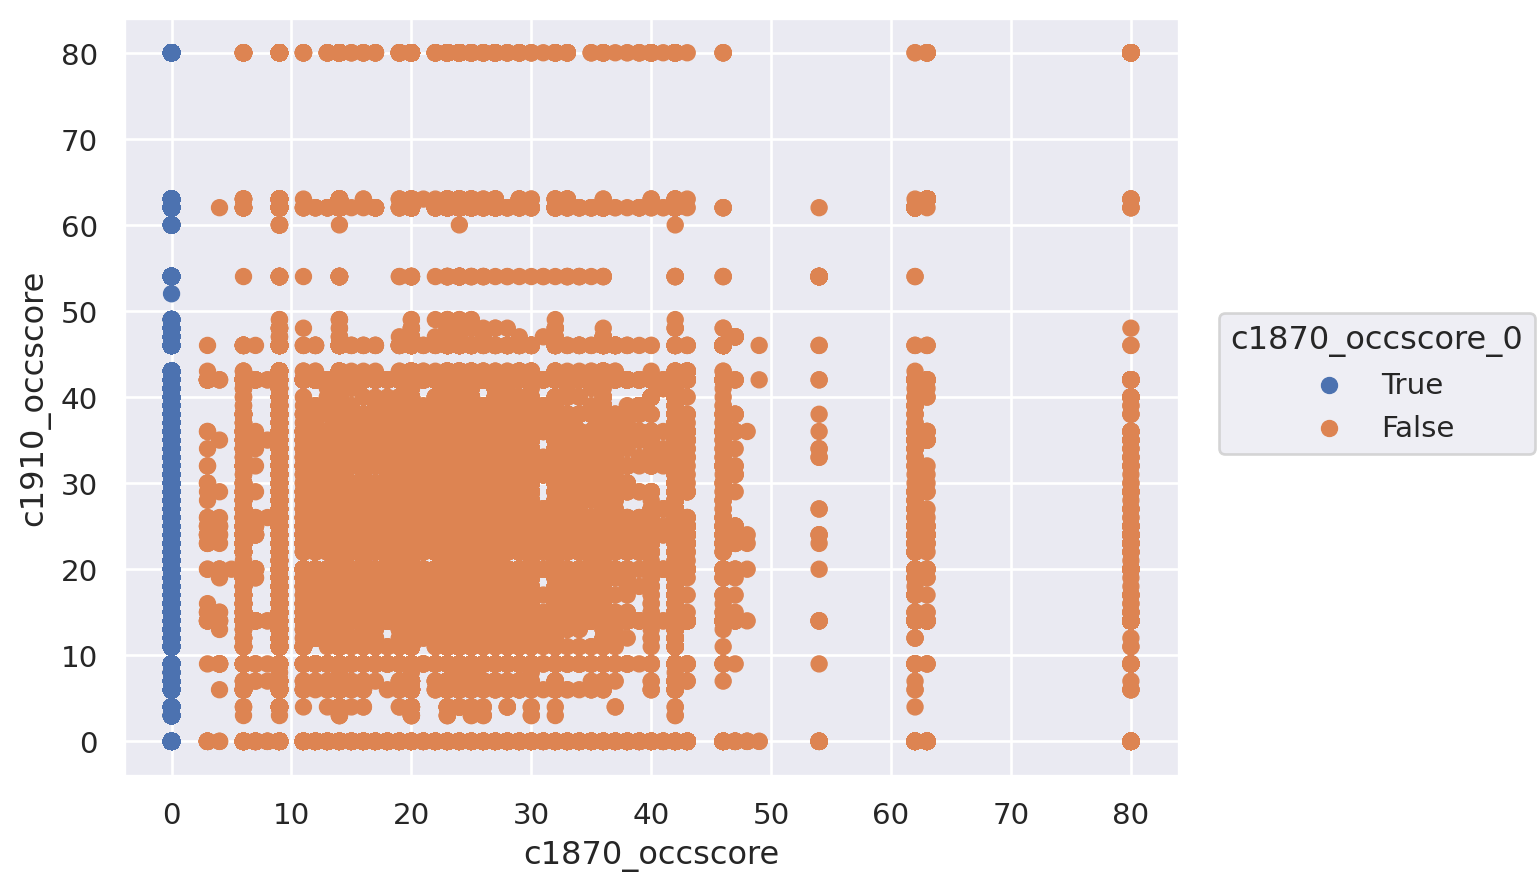

In [8]:
dmd('#### Unlinked:')

one_pct['age_squared'] = one_pct['AGE']**2
m1 = smf.ols('OCCSCORE ~ 1 + C(YEAR) + AGE + age_squared', data = one_pct ).fit(cov_type = 'HC0')
summary_col(m1, stars = True)


dmd('__Regressions on linked dataset of impact of not having occscore at first on not having occscore at second. Uses logits though.__ \n\n')

# linked:
by_itself = smf.logit('c1910_occscore_0 ~ 1 + c1870_occscore_0',data = forreg).fit()
with_age = smf.logit('c1910_occscore_0 ~ 1 + c1870_occscore_0 + c1870_age + c1870_age:c1870_occscore_0 + c1870_occscore_0:age_squared',data = forreg).fit()
by_itself_linear = smf.ols('c1910_occscore_0 ~ 1 + c1870_occscore_0',data = forreg).fit(cov_type='HC0')
with_age_linear = smf.ols('c1910_occscore_0 ~ 1 + c1870_occscore_0 + c1870_age + c1870_age:c1870_occscore_0 + c1870_occscore_0:age_squared',data = forreg).fit(cov_type='HC0')
summary_col([by_itself, with_age, by_itself_linear, with_age_linear ], stars = True, model_names = ['By Itself', 'With Age', 'By Itself Linear', 'With Age Linear'])

dmd('\n\n #### Plot')
(
    so.Plot(combined, x = 'c1870_occscore', y = 'c1910_occscore', color = 'c1870_occscore_0')
    .add(so.Dot()) 
)

 ### EDSCOR50

This variable is an estimated percent chance of them having at least one year of college education. This is based on the 1950 census, and is using 1950 occupational categories to do the estimation. This will be problematic for a couple reasons. First off, literacy is very very related to percent chance of being linked in the first place. If you look below, you can see both the overall and split by race categories are heavily impacted. Second, literacy _is_ a form of education, which makes this even more complicated. All the variables pretty much have this problem, though. Unfortunate, but the best we can really do in this situation.  

In [9]:
# Full dataset Mean edscor50 by race
print('Full dataset mean edscore50 by race')
pd.pivot_table(one_pct[one_pct.YEAR == 1870], values = ['edscor50', 'OCCSCORE', 'lit'], index = 'not_white', aggfunc = 'mean', margins=True, sort=False)


print('Linked mean edscor50 and occscore')

pd.pivot_table(combined, values = ['c1870_occscore', 'c1870_edscor50', 'c1870_lit'], index = 'not_white',  aggfunc = 'mean',   margins = True, sort = False)

Full dataset mean edscore50 by race


,edscor50,OCCSCORE,lit
not_white,,,
0,2.672299,5.726321,0.664598
1,1.632862,5.055054,0.195398
All,2.540660,5.641309,0.605176


Linked mean edscor50 and occscore


,c1870_occscore,c1870_edscor50,c1870_lit
not_white,,,
False,7.016287,3.034022,0.582167
True,5.742842,1.912048,0.238922
All,6.917581,2.947057,0.555562


### Stateicp

This is pretty much the most important variable here, because it's what the model will be using for geographic variation. While I often mention 'state' in this paper, that is not quite accurate. There are non-state territories in the ICP coding system, and I included those as well. Included, there is a icp_conversion.csv file that has to mapping between the encodings of the state names and ICP codes I used. The ones used in the model later are different entirely, and is from an index I just created in SQL, as it had to be in order and not skip any for pymc to let it work. 

I also generated the 'state_changed' variable, which is just a boolean of whether or not they moved states between the two census years. This is important, as it allows us to see if there is any difference in the trajectories of those who moved states and those who stayed in the same state, a primary question posed by this paper.

### State Distance 

I used a dataset I found on github to generate a big list of distances from state to state, then joined that csv into a special dataframe. I did this with the 10% model only since by the time I did all of this I had already discovered the extra time largely wasn't worth it. 

### Race

For this variable I decided to encode it in a quite simple "not_white" scheme, as I found that that would greatly simplify things as all non black or white races were very rare in the dataset. If I was to collapse them into one category, including the dominant race as it's own category seems to make the most sense to me. This variable is used quite a lot within the analysis, as it is very important to this time period and one of the most clear cut variables likely to have distinct regional differences. 

The yearly difference causes some issues with linked too. I ended up doing a system where if the race values disagreed (on non-white status), then it would use the earlier value. Not certain this is the best way to handle it, but it seems to make more sense than the other way around.



In [10]:
# Descriptive Stats on Race
race_id_to_str = dict(zip(
    [1,2,3,4,5,6,7,8,9],
    ['White', 'Black/African American', 'American Indian or Alaskan Native', \
     'Chinese', 'Japanese', 'Other Asian or Pacific Islander', \
        'Other Race, nec', 'Two major races', 'Three or more major races']
))
one_pct['race_detailed'] = one_pct.RACE.replace(race_id_to_str)
one_pct['n'] = 1
one_pct.groupby('race_detailed').agg({'n': 'sum'}) \
    .reset_index() \
    .sort_values('n', ascending = False) \
    .assign(pct = lambda x: 100* x.n / x.n.sum()) 

,race_detailed,n,pct
5,White,1150980,88.324401
1,Black/African American,147321,11.305183
0,American Indian or Alaskan Native,2787,0.213870
2,Chinese,1278,0.098072
3,Japanese,756,0.058014
4,Other Asian or Pacific Islander,6,0.000460


### Age

Age is a very tricky one for this analysis. For one, it is essential to the whole exercise. Effectively, the entire goal is to observe someone over the course of their lifetime. Of course, then, the linked datasets will be drastically different before and after in terms of the age distribution. You can see this below in the histograms and the table. I can't really put age into the model directly outside of testing purposes for this reason, as it would be very endogenous. 

#### __All (including non linked)__

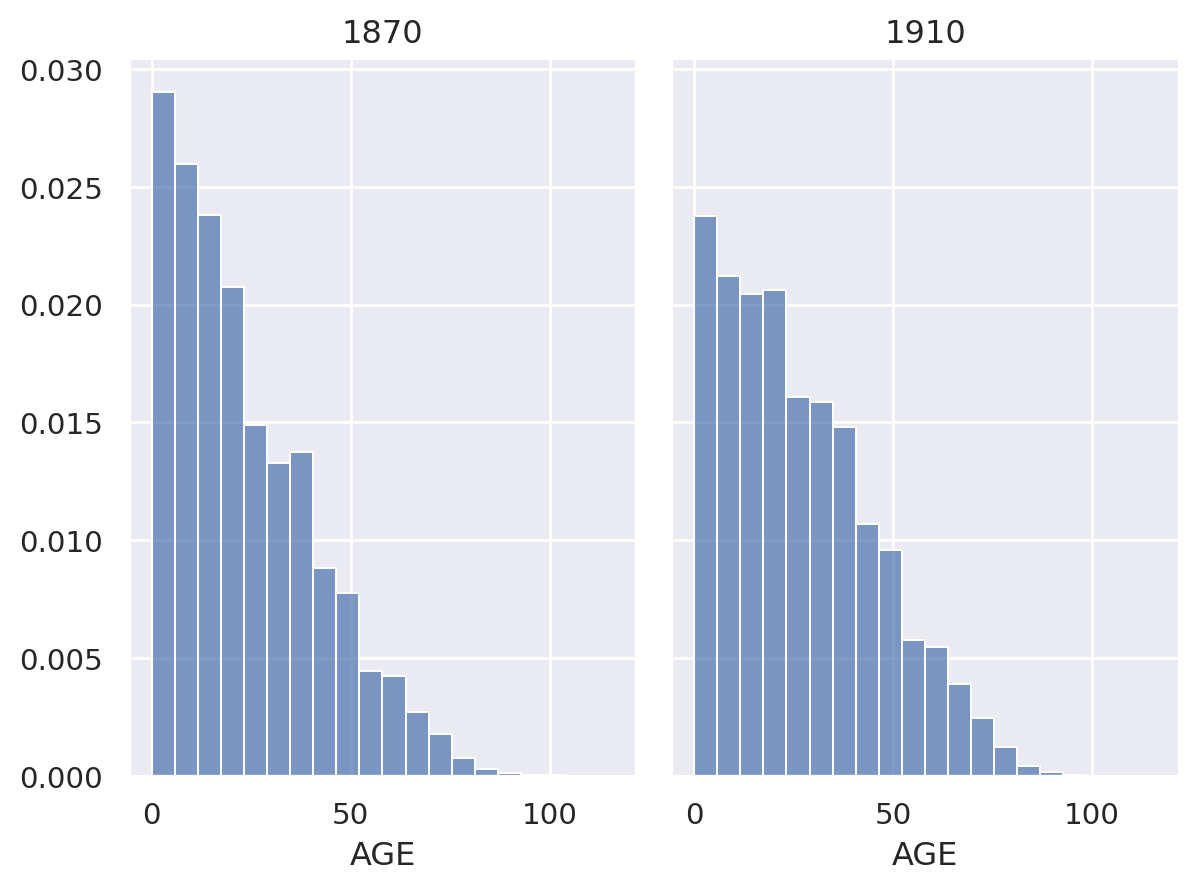

#### __ONLY linked__

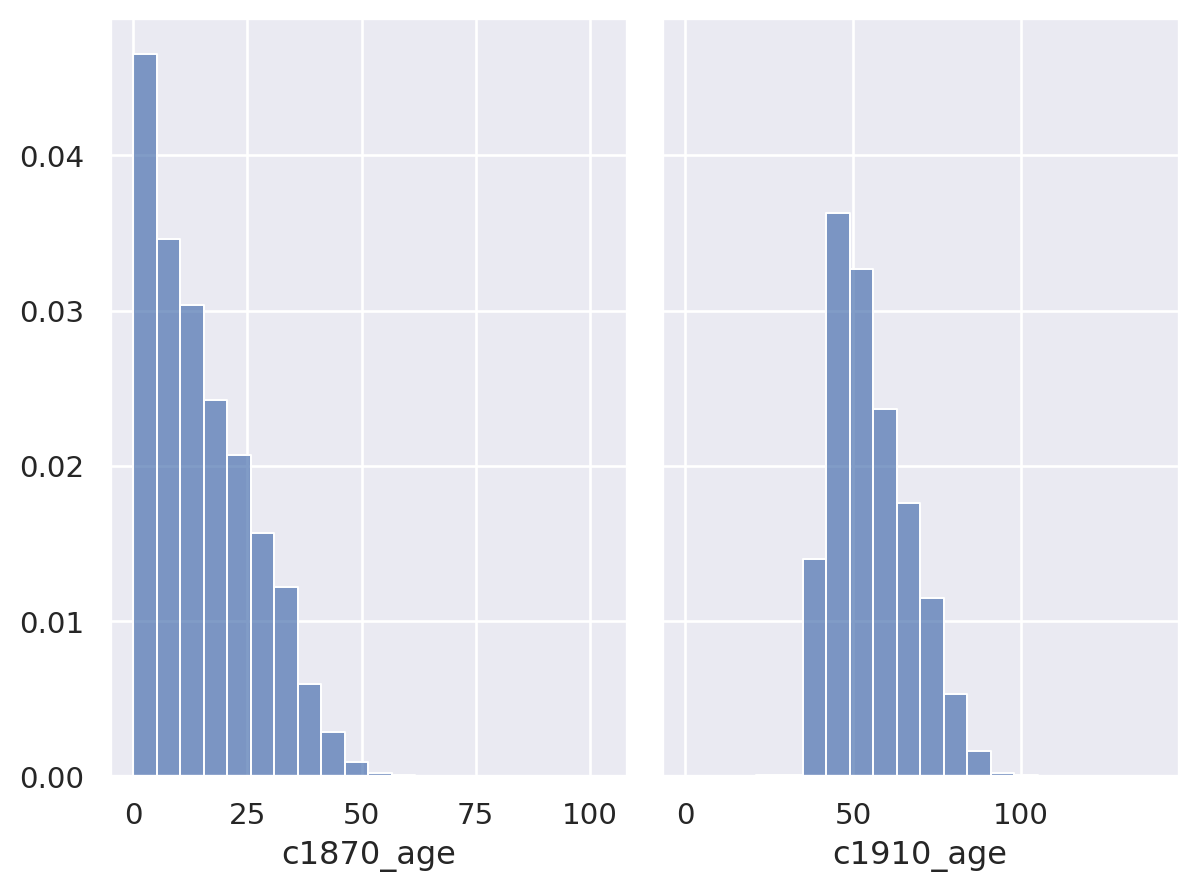

#### __Average Age by Year__

__All__

YEAR        AGE           
              mean        std
0  1870  23.482835  18.216810
1  1910  26.630187  19.074487

__Linked__

,mean,std
c1870_age,15.168708,11.339750
c1910_age,54.917268,11.486817


In [11]:
dmd('#### __All (including non linked)__')
(
    so.Plot(one_pct, x = 'AGE')
        .add(so.Bars(), so.Hist(bins = 20, stat = 'density'))
        .facet('YEAR')
    #.facet('YEAR')
)
dmd('#### __ONLY linked__')
(
    so.Plot(combined)
    .pair(x = ['c1870_age', 'c1910_age'])
    .add(so.Bars(), so.Hist(bins = 20, stat = 'density'))
    #.facet('YEAR')
)

dmd('#### __Average Age by Year__')

dmd('__All__')
one_pct.groupby('YEAR').agg({'AGE': ['mean', 'std']}).reset_index()
dmd('__Linked__')
combined.agg({'c1870_age': ['mean', 'std'], 'c1910_age': ['mean', 'std']}).transpose()

# Statistical Statement / Model 

## Background 

This model is fundamentally a much expanded and bayesian flavor of a project I did for another class. In this project, I analyzed only Virginia data and compared that with specifically within Williamsburg. While this was informative, I was restricted by both inadequite tooling and a limited geographic location. Within state variation is interesting, but it is also important to understand how this varies across the country. The goal of this project is to get a bigger look into the regional composition of this effect, and be able to model entire distributions at once.  

## Dependent Variables 

All models have one of two dependent variables: 

1. Change in Log Earnigns: 
$$\Theta_{inc} =  ln(OCCSCORE_{1910}) - ln(OCCSCORE_{1870})$$

2. Change in percent chance of having at least one year of college education:

$$\Theta_{edu} = EDSCOR50_{1910} - EDSCOR50_{1870}$$

The change in log earnings should approximate (very roughly, breaks down with large changes) percent chance in income. Education variable is already a percent estimate so I just left it be the raw change. 

## Hyperpriors 

I chose pretty similar priors across all the groups. For the sigmas, I always used HalfCauchy with either beta = 2 or beta = 3. For the betas I used either uniform or normal. 


### Simple Race Models 

For the simple models only dealing with race as a coefficient in the regression equation, I (roughly) targeted the priors to the means of a similar overall linear model for the whole country, but kept the standard deviations and the distribution of the mu's quite large. They shouldn't be that informative, but I think it helped speed up training a bit. The exact priors I used are below.
For log earnings: 




## Technical Information

###  Various Datasets 

There are two main variations of the primary dataset. The first is just the Census linking project's standard nysiis match, and the second is their more conservative matching standard. Some of these I sampled into smaller datasets to test things and save time, but the full dataset is the one used for the final analysis. The models themselves are somewhat all over the place, but that is because the log wage standard full datasets flat out failed after 8+ hours of running on an A100 somehow, and errored out most of the way through. The education ones didn't crash, strangely. 


| Codename | Description | Models used in | 
| --- | --- | --- |
| conservative_full | Full dataset, conservative match | ln_wages | 
| conservative_10pct | 10% sample, conservative match | ln_wages_age, ln_wages_state_change, both state distance models |
| conservative_25pct | 25% sample, conservative match | ln_wages |
| std_full | Full dataset, standard match | edu_race, ln_wages_state_change |
| std_10pct | 10% sample, standard match | N/A |
| std_25pct | 25% sample, standard match | ln_wages_conservative_25pct |


Each file is named `comb_1870_1910_{codename}.parquet`, with `comb` standing for combined. 

### Centered vs Non-Centered

All of the models were run in a non-centered way for performance reasons. I tried one without it, but it was not worth the time. The model is complicated enough a non-centered approach definitely makes sense. 

### Very bad bug

After running a large number of my models and being almost done, I just now spotted a bug where any model with a beta 3 has it using the beta 1 offset. Now, all that does is generate a mu 0 sigma 1 random sample, but they would be correlated together when sampling. This effected multiple of my models, unfortunately. I have fixed it now, but I am not going to rerun all of them. 
 
## Practical Problems

This project in general ran into some _very_ serious technical problems. The most important of these was just getting the model to runa at all. It straight up does not run whatsoever on my own machine, even when I only run it on a random sample of the full dataset. I tried quite a few things, mainly switching the backend to JAX (Numpyro), which allows it to be JIT compiled. This made it technically start running, but basically had zero progress. From there, I ended up putting it on Google cloud and just eating the cost. Most of the model were run on a VM with a Nvidia A100 GPU, except one which I had running on a V100. Each one took around 7 hours, and I had to redo them a few times. I had original plans to run the model on the raw dataset as well, not just the linked one, but I don't think that would be practical given how absolutely massive it is. There may be something with my model causing this, but I wasn't able to identify it. I'll discuss this further in the model section.

## Model Specification

### ln_wages

This is the simplest of all the models shown. It has the following specification: 

Hyperpriors:
$$
\begin{aligned}
\mu_{\beta_0} &\sim N(1.9,1.5)\\
\sigma_{\beta_0} &\sim HalfCauchy(2)\\
\mu_{\beta_1} &\sim N(-1, 1.5)\\
\sigma_{\beta_1} &\sim HalfCauchy(2)\\
\sigma &\sim HalfCauchy(2)\\
\end{aligned}
$$

Group Priors: 

$$
\begin{aligned}
\beta_{0i} &\sim N(\mu_{\beta_0}, \sigma_{\beta_0})\\
\beta_{1i} &\sim N(\mu_{\beta_1}, \sigma_{\beta_1}) \\
\end{aligned}
$$

Deterministic: 

$$
\begin{aligned}
\mu_{i} = \beta_{0i} + \beta_{1i} not\_white_{i} \\
\end{aligned}
$$

For the hyperpriors on this model, I roughly put the mean on a mean generated by a simple linear regression for the whole country, and made the SD large compared to the real SD, but still in a general range. This was just to help the model converge faster. All sigmas are just HalfCauchy with beta = 2. So slightly informative priors but not really that much. The group priors are just the hierarchal splitting by state, using the ICP code (The index used is not actually the ICP code, I have a csv converting it). This model itself is a very simple regression with race as the only variable, and is the simplest model here. This model was run on the conservative_full dataset, and used conservative linking. The standard model unfortunately failed to run in it's full form, although a 25% model did manage to run. 

The code used to run the model is below:

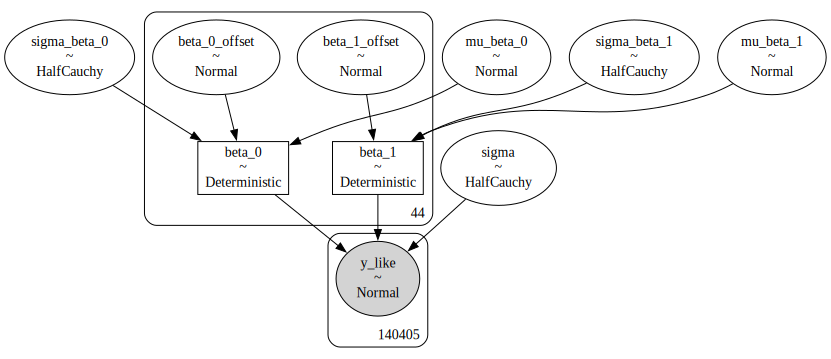

In [ ]:
# ln_wages_conservative_full 
# Used conservative linking

def ln_wages_conservative(data, y_hat_str):
    shape_val = data['origin_state_idx'].nunique()
    with pm.Model() as model:
        # Priors
        mu_beta_0 = pm.Normal('mu_beta_0', mu = 1.9, sigma = 1.5)
        sigma_beta_0 = pm.HalfCauchy('sigma_beta_0', beta = 2)
        mu_beta_1 = pm.Normal('mu_beta_1', mu = -1, sigma = 1.5)
        sigma_beta_1 = pm.HalfCauchy('sigma_beta_1', beta = 2)
        sigma = pm.HalfCauchy('sigma', beta = 2)

        # Hierarchical Priors
        beta_0_offset = pm.Normal('beta_0_offset', mu=0, sigma=1, shape = shape_val)
        beta_0 = pm.Deterministic('beta_0', mu_beta_0 + beta_0_offset * sigma_beta_0)

        beta_1_offset = pm.Normal('beta_1_offset', mu=0, sigma=1, shape = shape_val)
        beta_1 = pm.Deterministic('beta_1', mu_beta_1 + beta_1_offset * sigma_beta_1)

        # Deterministic

        mu_all = beta_0[data.origin_state_idx] + beta_1[data.origin_state_idx] * data.not_white  

        # Likelihood

        y_like = pm.Normal('y_like', mu=mu_all, sigma=sigma, observed=data[y_hat_str])

    return model

# IF YOU WANT TO ACTUALLY RUN THIS, UNCOMMENT OUT ONE OF THESE DATASETS!!!!!
# 10pct
dataset = comb_1870_1910_conservative_full_10pct
# 25pct
# dataset = comb_1870_1910_conservative_full_25pct
# full
# dataset = comb_1870_1910_conservative_full
model = ln_wages_conservative(dataset, 'log_earnings_change')
with model:
    ### YOU MUST CHOOSE ONE _IF_ YOU WANT TO RUN THIS. Nothing else in this document assumes you will run this.
# JAX
    #ln_wages_conservative_trace = pm_jax.sample_numpyro_nuts(4000, return_inferencedata=True, progressbar=True, chain_method = 'vectorized')
# Normal NUTS (Might run slower)
    #ln_wages_conservative_trace = pm.sample(draws = 4000, return_inferencedata=True, progressbar=True)
    pass
pm.model_to_graphviz(model)


In [ ]:
#At the end of the last slide there should be a graphviz diagram showing up. If there is not, run this cell!

pm.model_to_graphviz(model).view()


### edu_race

$$
\begin{aligned}
\mu_{\beta_0} &\sim N(6.5,1.5)\\
\sigma_{\beta_0} &\sim HalfCauchy(2)\\
\mu_{\beta_1} &\sim N(-2.5, 1.5)\\
\sigma_{\beta_1} &\sim HalfCauchy(2)\\
\sigma &\sim HalfCauchy(2)\\
\end{aligned}
$$

Group Priors: 

$$
\begin{aligned}
\beta_{0i} &\sim N(\mu_{\beta_0}, \sigma_{\beta_0})\\
\beta_{1i} &\sim N(\mu_{\beta_1}, \sigma_{\beta_1}) \\
\end{aligned}
$$

Deterministic: 

$$
\begin{aligned}
\mu_{i} = \beta_{0i} + \beta_{1i} not\_white_{i} \\
\end{aligned}
$$


This is a very very similar model to the last one, but targeting education instead. The main difference is I set up different, but similarly calculated values for the priors to help with convergence. They were different because the outcome variable this time was education. 

The code used to run the model is below. I ran this only on the standard (non-conservative) dataset. No education models were run on the conservative dataset.

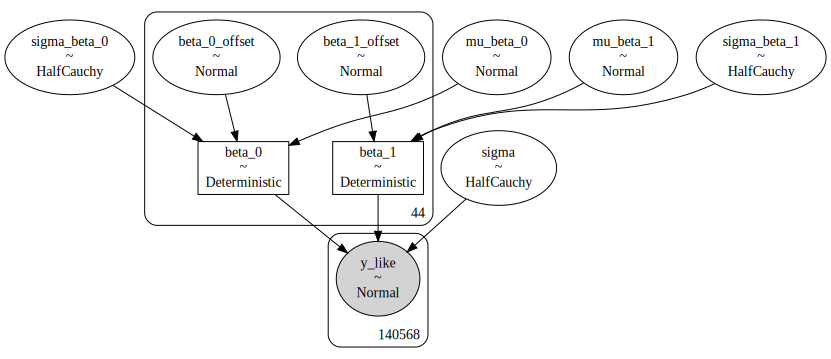

In [ ]:

# edu_race_std_full
def edu_race_std(data):
    shape_val = data['origin_state_idx'].nunique()
    with pm.Model() as model:
        # Priors
        mu_beta_0 = pm.Normal('mu_beta_0', mu = 6.5, sigma = 1.5)
        sigma_beta_0 = pm.HalfCauchy('sigma_beta_0', beta = 2)
        mu_beta_1 = pm.Normal('mu_beta_1', mu = -2.5, sigma = 1.5)
        sigma_beta_1 = pm.HalfCauchy('sigma_beta_1', beta = 2)
        sigma = pm.HalfCauchy('sigma', beta = 2)

        # Hierarchical Priors
        beta_0_offset = pm.Normal('beta_0_offset', mu=0, sigma=1, shape = shape_val)
        beta_0 = pm.Deterministic('beta_0', mu_beta_0 + beta_0_offset * sigma_beta_0)

        beta_1_offset = pm.Normal('beta_1_offset', mu=0, sigma=1, shape = shape_val)
        beta_1 = pm.Deterministic('beta_1', mu_beta_1 + beta_1_offset * sigma_beta_1)

        # Deterministic

        mu_all = beta_0[data.origin_state_idx] + beta_1[data.origin_state_idx] * data.not_white  

        # Likelihood

        y_like = pm.Normal('y_like', mu=mu_all, sigma=sigma, observed=data.edscor50_change)

    return model

# IF YOU WANT TO ACTUALLY RUN THIS, UNCOMMENT OUT ONE OF THESE DATASETS!!!!!
# 10pct
dataset = comb_1870_1910_std_full_10pct
# 25pct
#dataset = comb_1870_1910_std_full_25pct
# full
#dataset = comb_1870_1910_std_full
model = edu_race_std(dataset)
with model:
    ### YOU MUST CHOOSE ONE _IF_ YOU WANT TO RUN THIS. Nothing else in this document assumes you will run this.
# JAX
    #edu_race_std_trace = pm_jax.sample_numpyro_nuts(4000, return_inferencedata=True, progressbar=True, chain_method = 'vectorized')
# Normal NUTS (Might run slower)
    #edu_race_std_trace = pm.sample(draws = 4000, return_inferencedata=True, progressbar=True)
    pass
pm.model_to_graphviz(model)


In [ ]:

#At the end of the last slide there should be a graphviz diagram showing up. If there is not, run this cell!

pm.model_to_graphviz(model).view()

'.gv.pdf'


### Log Earnings State Change / Distance with race

$$
\begin{aligned}
\mu_{\beta_0} &\sim Uniform(-10, 10)\\
\sigma_{\beta_0} &\sim HalfCauchy(2)\\
\mu_{\beta_1} &\sim N(-10, 10)\\
\sigma_{\beta_1} &\sim HalfCauchy(2)\\
\mu_{\beta_2} &\sim N(-10, 10)\\
\sigma_{\beta_2} &\sim HalfCauchy(2)\\
\mu_{\beta_3} &\sim N(-10, 10)\\
\sigma_{\beta_3} &\sim HalfCauchy(2)\\
\sigma &\sim HalfCauchy(2)\\
\end{aligned}
$$

Group Priors: 

$$
\begin{aligned}
\beta_{0i} &\sim N(\mu_{\beta_0}, \sigma_{\beta_0})\\
\beta_{1i} &\sim N(\mu_{\beta_1}, \sigma_{\beta_1}) \\
\beta_{2i} &\sim N(\mu_{\beta_2}, \sigma_{\beta_2}) \\
\beta_{3i} &\sim N(\mu_{\beta_3}, \sigma_{\beta_3}) \\
\end{aligned}
$$

Deterministic: 


1.   List item
2.   List item


$$
\begin{aligned}
\mu_{i} = \beta_{0i} + \beta_{1i} not\_white_{i} + \beta_{2i} state\_changed_i + \beta_{3i} state\_changed_i \times not\_white_i \\
\end{aligned}
$$

This is also a 'state distance w/ race' model, you only need to swap out the state_changed with state_distance. That is what I did. I will include the code for both below.


This is the most interesting and important of the models I created. It is more difficult to estimate, with the regression requiring more parameters distributions to be estimated, but it very important to the primary question of interest. The census tracts where you live in both years. For the geographic area in the model, I defaulted to where you have ended up. In this model, I added a term to the regression in two areas that indicate you now live in a different state. I also interacted these terms with race and measured the log earnings change. The effect here is to see if people who changed states end up in better life outcomes, and to see if that is different depending on your race or what location you were from originally.

The code used to run the model is below. I ran this only on the standard (non-conservative) dataset. Additionally there was a weird bug where I used the same offset variable for two variables. It's just a random N(0,1) offset so I'm not sure if it will matter but I added an additional 10% model just in case. 

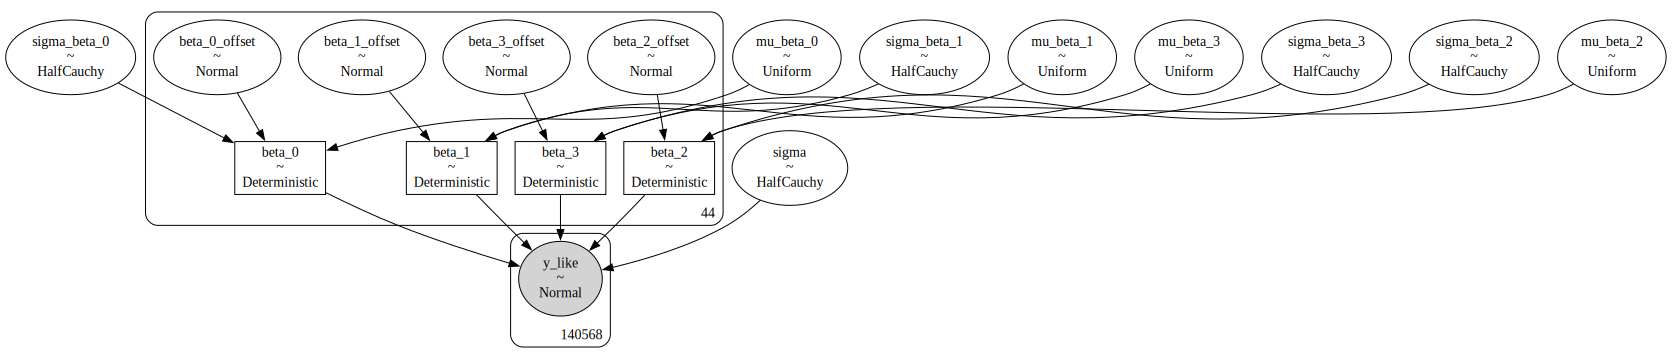

In [ ]:

# ln_wages_state_change_std_full (codename I gave trace file)
# full nysiis
def ln_wages_state_change(data, y_hat_str):
    shape_val = data['origin_state_idx'].nunique()
    with pm.Model() as model:
        # Priors
        mu_beta_0 = pm.Uniform('mu_beta_0', lower=-10, upper=10)
        sigma_beta_0 = pm.HalfCauchy('sigma_beta_0', beta = 2)
        mu_beta_1 = pm.Uniform('mu_beta_1', lower=-10, upper=10)
        sigma_beta_1 = pm.HalfCauchy('sigma_beta_1', beta = 2)
        mu_beta_2 = pm.Uniform('mu_beta_2', lower=-10, upper=10)
        sigma_beta_2 = pm.HalfCauchy('sigma_beta_2', beta = 2)
        mu_beta_3 = pm.Uniform('mu_beta_3', lower=-10, upper=10)
        sigma_beta_3 = pm.HalfCauchy('sigma_beta_3', beta = 2)
        sigma = pm.HalfCauchy('sigma', beta = 2)

        # Hierarchical Priors
        beta_0_offset = pm.Normal('beta_0_offset', mu=0, sigma=1, shape = shape_val)
        beta_0 = pm.Deterministic('beta_0', mu_beta_0 + beta_0_offset * sigma_beta_0)

        beta_1_offset = pm.Normal('beta_1_offset', mu=0, sigma=1, shape = shape_val)
        beta_1 = pm.Deterministic('beta_1', mu_beta_1 + beta_1_offset * sigma_beta_1)
        beta_2_offset = pm.Normal('beta_2_offset', mu=0, sigma=1, shape = shape_val)
        beta_2 = pm.Deterministic('beta_2', mu_beta_2 + beta_2_offset * sigma_beta_2)
        beta_3_offset = pm.Normal('beta_3_offset', mu=0, sigma=1, shape = shape_val)
        beta_3 = pm.Deterministic('beta_3', mu_beta_3 + beta_3_offset * sigma_beta_3)
        # THERE WAS ORIGINALLY A TYPO HERE! I fixed it for the 10% model. 
        

        # Deterministic

        mu_all = beta_0[data.origin_state_idx] + beta_1[data.origin_state_idx] * data.not_white \
                + beta_2[data.origin_state_idx] * data.state_changed + beta_3[data.origin_state_idx]*data.state_changed * data.not_white
        # Likelihood

        y_like = pm.Normal('y_like', mu=mu_all, sigma=sigma, observed=data[y_hat_str])

    return model

# IF YOU WANT TO ACTUALLY RUN THIS, UNCOMMENT OUT ONE OF THESE DATASETS!!!!!
# 10pct
dataset = comb_1870_1910_std_full_10pct
# 25pct
#dataset = comb_1870_1910_std_full_25pct
# full
#dataset = comb_1870_1910_std_full
model = ln_wages_state_change(dataset, 'log_earnings_change')
with model:
    ### YOU MUST CHOOSE ONE _IF_ YOU WANT TO RUN THIS. Nothing else in this document assumes you will run this.
# JAX
    #ln_wages_state_change_trace = pm_jax.sample_numpyro_nuts(4000, return_inferencedata=True, progressbar=True, chain_method = 'vectorized')
# Normal NUTS (Might run slower)
    #ln_wages_state_change_trace = pm.sample(draws = 4000, return_inferencedata=True, progressbar=True)
    pass
pm.model_to_graphviz(model)

In [ ]:
#At the end of the last slide there should be a graphviz diagram showing up. If there is not, run this cell!

pm.model_to_graphviz(model).view()

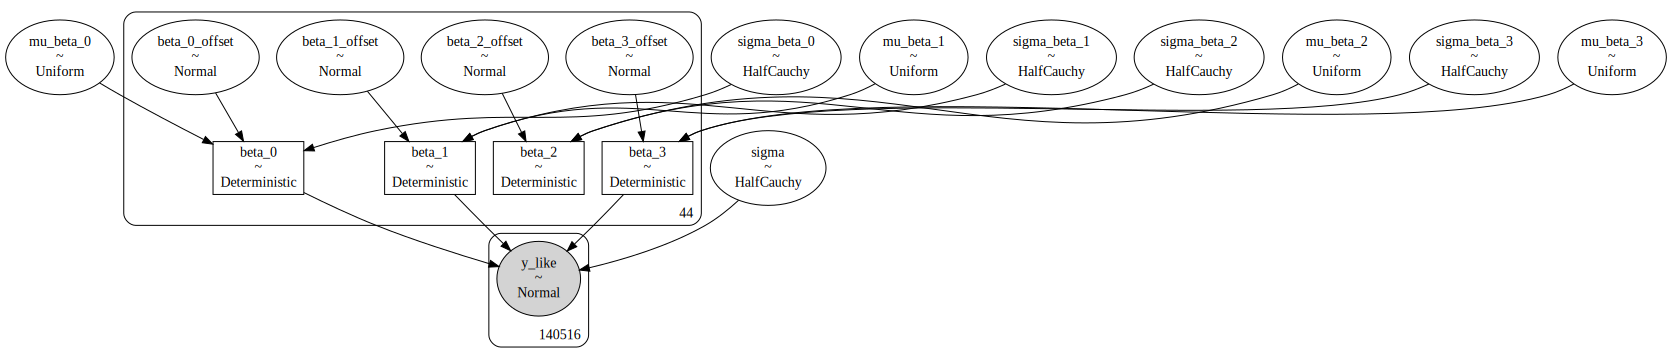

In [ ]:
def state_dist_race_model(data, y_hat_str):
    shape_val = data['origin_state_idx'].nunique()
    with pm.Model() as model:
        # Priors
        mu_beta_0 = pm.Uniform('mu_beta_0', lower=-10, upper=10)
        sigma_beta_0 = pm.HalfCauchy('sigma_beta_0', beta = 2)
        mu_beta_1 = pm.Uniform('mu_beta_1', lower=-10, upper=10)
        sigma_beta_1 = pm.HalfCauchy('sigma_beta_1', beta = 2)
        mu_beta_2 = pm.Uniform('mu_beta_2', lower=-10, upper=10)
        sigma_beta_2 = pm.HalfCauchy('sigma_beta_2', beta = 2)
        mu_beta_3 = pm.Uniform('mu_beta_3', lower=-10, upper=10)
        sigma_beta_3 = pm.HalfCauchy('sigma_beta_3', beta = 2)
        sigma = pm.HalfCauchy('sigma', beta = 2)

        # Hierarchical Priors
        beta_0_offset = pm.Normal('beta_0_offset', mu=0, sigma=1, shape = shape_val)
        beta_0 = pm.Deterministic('beta_0', mu_beta_0 + beta_0_offset * sigma_beta_0)

        beta_1_offset = pm.Normal('beta_1_offset', mu=0, sigma=1, shape = shape_val)
        beta_1 = pm.Deterministic('beta_1', mu_beta_1 + beta_1_offset * sigma_beta_1)
        beta_2_offset = pm.Normal('beta_2_offset', mu=0, sigma=1, shape = shape_val)
        beta_2 = pm.Deterministic('beta_2', mu_beta_2 + beta_2_offset * sigma_beta_2)
        beta_3_offset = pm.Normal('beta_3_offset', mu=0, sigma=1, shape = shape_val)
        beta_3 = pm.Deterministic('beta_3', mu_beta_3 + beta_3_offset * sigma_beta_3)


        # Deterministic

        mu_all = beta_0[data.origin_state_idx] + beta_1[data.origin_state_idx] * data.state_dist + \
               beta_2[data.origin_state_idx]*data.not_white +  beta_3[data.origin_state_idx] * data.state_dist * data.not_white
        # Likelihood

        y_like = pm.Normal('y_like', mu=mu_all, sigma=sigma, observed=data[y_hat_str])

    return model
#Only works with this dataset
dataset = state_dist_dataset_special

model = state_dist_race_model(dataset, 'log_earnings_change')
with model:
    ### YOU MUST CHOOSE ONE _IF_ YOU WANT TO RUN THIS. Nothing else in this document assumes you will run this.
# JAX
    #ln_wages_state_change_trace = pm_jax.sample_numpyro_nuts(4000, return_inferencedata=True, progressbar=True, chain_method = 'vectorized')
# Normal NUTS (Might run slower)
    #ln_wages_state_change_trace = pm.sample(draws = 4000, return_inferencedata=True, progressbar=True)
    pass
pm.model_to_graphviz(model)



### Log Earnings State Distance (w/o race) 

$$
\begin{aligned}
\mu_{\beta_0} &\sim Uniform(-10, 10)\\
\sigma_{\beta_0} &\sim HalfCauchy(2)\\
\mu_{\beta_1} &\sim N(-10, 10)\\
\sigma_{\beta_1} &\sim HalfCauchy(2)\\
\sigma &\sim HalfCauchy(2)\\
\end{aligned}
$$

Group Priors: 

$$
\begin{aligned}
\beta_{0i} &\sim N(\mu_{\beta_0}, \sigma_{\beta_0})\\
\beta_{1i} &\sim N(\mu_{\beta_1}, \sigma_{\beta_1}) \\
\end{aligned}
$$

Deterministic: 

$$
\begin{aligned}
\mu_{i} = \beta_{0i} + \beta_{1i} state\_dist_{i} 
\end{aligned}
$$


This is a very simple modification of the base state_dist w/ race model for comparisons sake. model below. 

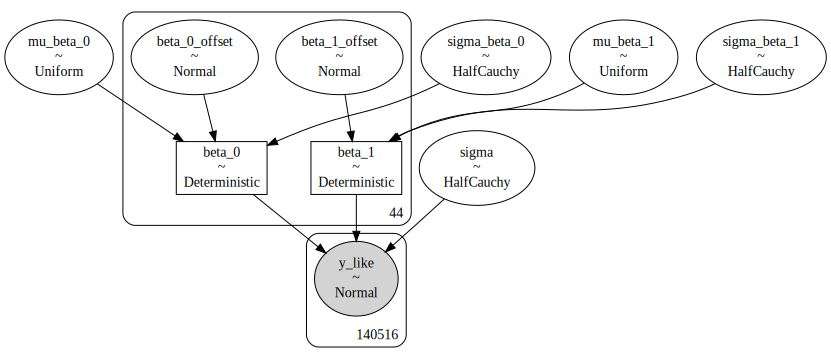

In [ ]:
def state_dist_basic_model(data, y_hat_str):
    shape_val = data['origin_state_idx'].nunique()
    with pm.Model() as model:
        # Priors
        mu_beta_0 = pm.Uniform('mu_beta_0', lower=-10, upper=10)
        sigma_beta_0 = pm.HalfCauchy('sigma_beta_0', beta = 2)
        mu_beta_1 = pm.Uniform('mu_beta_1', lower=-10, upper=10)
        sigma_beta_1 = pm.HalfCauchy('sigma_beta_1', beta = 2)
        sigma = pm.HalfCauchy('sigma', beta = 2)

        # Hierarchical Priors
        beta_0_offset = pm.Normal('beta_0_offset', mu=0, sigma=1, shape = shape_val)
        beta_0 = pm.Deterministic('beta_0', mu_beta_0 + beta_0_offset * sigma_beta_0)

        beta_1_offset = pm.Normal('beta_1_offset', mu=0, sigma=1, shape = shape_val)
        beta_1 = pm.Deterministic('beta_1', mu_beta_1 + beta_1_offset * sigma_beta_1)

        # Deterministic

        mu_all = beta_0[data.origin_state_idx] + beta_1[data.origin_state_idx] * data.state_dist 
        # Likelihood

        y_like = pm.Normal('y_like', mu=mu_all, sigma=sigma, observed=data[y_hat_str])

    return model
#Only works with this dataset
dataset = state_dist_dataset_special

model = state_dist_basic_model(dataset, 'log_earnings_change')
with model:
    ### YOU MUST CHOOSE ONE _IF_ YOU WANT TO RUN THIS. Nothing else in this document assumes you will run this.
# JAX
    #ln_wages_state_change_trace = pm_jax.sample_numpyro_nuts(4000, return_inferencedata=True, progressbar=True, chain_method = 'vectorized')
# Normal NUTS (Might run slower)
    #ln_wages_state_change_trace = pm.sample(draws = 4000, return_inferencedata=True, progressbar=True)
    pass
pm.model_to_graphviz(model)


### Age and Race Model 

$$
\begin{aligned}
\mu_{\beta_0} &\sim Uniform(-10, 10)\\
\sigma_{\beta_0} &\sim HalfCauchy(2)\\
\mu_{\beta_1} &\sim N(-10, 10)\\
\sigma_{\beta_1} &\sim HalfCauchy(2)\\
\mu_{\beta_2} &\sim N(-50, 50)\\
\sigma_{\beta_2} &\sim HalfCauchy(3)\\
\mu_{\beta_3} &\sim N(-50, 50)\\
\sigma_{\beta_3} &\sim HalfCauchy(3)\\
\sigma &\sim HalfCauchy(2)\\
\end{aligned}
$$

Group Priors: 

$$
\begin{aligned}
\beta_{0i} &\sim N(\mu_{\beta_0}, \sigma_{\beta_0})\\
\beta_{1i} &\sim N(\mu_{\beta_1}, \sigma_{\beta_1}) \\
\beta_{2i} &\sim N(\mu_{\beta_2}, \sigma_{\beta_2}) \\
\beta_{3i} &\sim N(\mu_{\beta_3}, \sigma_{\beta_3}) \\
\end{aligned}
$$

Deterministic: 

$$
\begin{aligned}
\mu_{i} = \beta_{0i} + \beta_{1i} not\_white_{i} + \beta_{2i} age_i + \beta_{3i} age_i \times not\_white_i \\
\end{aligned}
$$

This model was mostly made out of curiosity after I saw the histograms around ace in earlier data exploration. Essentially, the time cutoff and linking means almost all the people who are linked are by necessity older. I wanted to see if outright controlling for age made any large differences. Now, this may introduce addtional endogeneity issues, but I think it is still interesting to see.

The code used to run the model is below. I ran this only on the conservative dataset. Additionally there was a weird bug where I used the same offset variable for two variables. It's just a random N(0,1) offset so I'm not sure if it will matter but I added an additional 10% model just in case. 

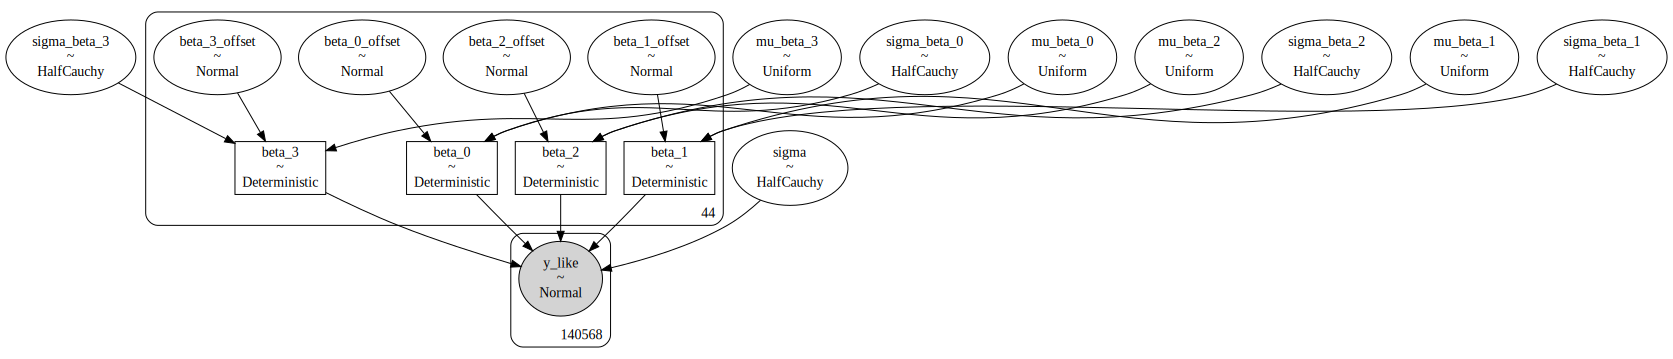

In [ ]:

# ln_wage_age_conservative_10pct 
def ln_wage_age(data, y_hat_str):
    shape_val = data['origin_state_idx'].nunique()
    with pm.Model() as model:
        # Priors
        mu_beta_0 = pm.Uniform('mu_beta_0', lower=-10, upper=10)
        sigma_beta_0 = pm.HalfCauchy('sigma_beta_0', beta = 2)
        mu_beta_1 = pm.Uniform('mu_beta_1', lower=-10, upper=10)
        sigma_beta_1 = pm.HalfCauchy('sigma_beta_1', beta = 2)
        mu_beta_2 = pm.Uniform('mu_beta_2', lower=-50, upper=50)
        sigma_beta_2 = pm.HalfCauchy('sigma_beta_2', beta = 3)
        mu_beta_3 = pm.Uniform('mu_beta_3', lower=-50, upper=50)
        sigma_beta_3 = pm.HalfCauchy('sigma_beta_3', beta = 3)
        sigma = pm.HalfCauchy('sigma', beta = 2)

        # Hierarchical Priors
        beta_0_offset = pm.Normal('beta_0_offset', mu=0, sigma=1, shape = shape_val)
        beta_0 = pm.Deterministic('beta_0', mu_beta_0 + beta_0_offset * sigma_beta_0)

        beta_1_offset = pm.Normal('beta_1_offset', mu=0, sigma=1, shape = shape_val)
        beta_1 = pm.Deterministic('beta_1', mu_beta_1 + beta_1_offset * sigma_beta_1)
        beta_2_offset = pm.Normal('beta_2_offset', mu=0, sigma=1, shape = shape_val)
        beta_2 = pm.Deterministic('beta_2', mu_beta_2 + beta_2_offset * sigma_beta_2)
        beta_3_offset = pm.Normal('beta_3_offset', mu=0, sigma=1, shape = shape_val) # NOTE!!!! This WAS a typo. I fixed it with a 10% model.  
       # beta_3 = pm.Deterministic('beta_3', mu_beta_3 + beta_1_offset * sigma_beta_3)
        beta_3 = pm.Deterministic('beta_3', mu_beta_3 + beta_3_offset * sigma_beta_3)


        # Deterministic

        mu_all = beta_0[data.origin_state_idx] + beta_1[data.origin_state_idx] * data.not_white \
                + beta_2[data.origin_state_idx] * data.c1870_age + beta_3[data.origin_state_idx]*data.c1870_age * data.not_white
        # Likelihood

        y_like = pm.Normal('y_like', mu=mu_all, sigma=sigma, observed=data[y_hat_str])

    return model

# IF YOU WANT TO ACTUALLY RUN THIS, UNCOMMENT OUT ONE OF THESE DATASETS!!!!!
# 10pct
dataset = comb_1870_1910_std_full_10pct
# 25pct
#dataset = comb_1870_1910_std_full_25pct
# full
#dataset = comb_1870_1910_std_full
model = ln_wage_age(dataset, 'log_earnings_change')
with model:
    ### YOU MUST CHOOSE ONE _IF_ YOU WANT TO RUN THIS. Nothing else in this document assumes you will run this.
# JAX
    #ln_wages_state_change_trace = pm_jax.sample_numpyro_nuts(4000, return_inferencedata=True, progressbar=True, chain_method = 'vectorized')
# Normal NUTS (Might run slower)
    #ln_wages_state_change_trace = pm.sample(draws = 4000, return_inferencedata=True, progressbar=True)
    pass
pm.model_to_graphviz(model)



In [ ]:
#At the end of the last slide there should be a graphviz diagram showing up. If there is not, run this cell!

pm.model_to_graphviz(model).view()

'.gv.pdf'

__make sure you run this cell!__

In [13]:


def print_model_diag(chain, name = 'This Model', commentary = [None]*8, var_names = ['beta_0', 'beta_1'], var_not = [ '~beta_0_offset', '~beta_1_offset']):
    dmd(F'## __{name}__')   
    #dmd('#### __Rhat__ and other summary stats')
    #display(pm.su##).reset_index()
    dmd('#### __Trace Plots__')
    dmd('#### __Detailed Trace Plots__')
    az.plot_trace(chain, var_names = var_not);
    plt.savefig(f'Figures/{name}.pdf')
    for beta in var_names:
        dmd(F'#### __{beta}__')
        az.plot_trace(chain, var_names = [beta], compact=False)
        plt.savefig(f'Figures/{name}{beta}.pdf')
    dmd(f'__printed under Figures/ starting with {name}.pdf__')
    plt.close()
plt.ioff()


# Results 

# Convergence 

## Education Models 


This is a good place to start with analyzing the convergence, as there is currently only one education model out there. In terms of simple convergence, the model seems to have done quite well. There is not a single r_hat value above 1.01 at the very least, which is a very good sign. One interesting thing is that the ESS is honestly... weirdly good? Every model in this paper had 4000 draws from it, and almost all of the ESS values are far above the actual number sampled. Either way, there does not seem to be significant signs of autocorrelation. 

In [ ]:
dmd('## __Education and Race Model Diagnostics__')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    az.summary(edu_race_std_full_trace, var_names=['~beta_0_offset', '~beta_1_offset'])

## __Education and Race Model Diagnostics__

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta_0,6.977,0.164,6.663,7.275,0.006,0.004,826.0,1601.0,1.01
mu_beta_1,-2.417,0.161,-2.720,-2.113,0.003,0.002,3059.0,5219.0,1.00
sigma_beta_0,1.044,0.126,0.815,1.280,0.002,0.002,2586.0,5218.0,1.00
sigma_beta_1,0.820,0.137,0.583,1.086,0.002,0.001,4875.0,8231.0,1.00
sigma,17.810,0.008,17.795,17.825,0.000,0.000,16237.0,9136.0,1.00
beta_0[Connecticut (0)],7.923,0.087,7.762,8.091,0.001,0.000,17127.0,10682.0,1.00
beta_0[Maine (1)],7.268,0.076,7.130,7.413,0.001,0.000,17074.0,10147.0,1.00
beta_0[Massachusetts (2)],8.000,0.057,7.895,8.110,0.000,0.000,16877.0,12566.0,1.00
beta_0[New Hampshire (3)],7.649,0.109,7.455,7.860,0.001,0.001,20828.0,10663.0,1.00
beta_0[Rhode Island (4)],8.047,0.137,7.793,8.308,0.001,0.001,21946.0,10592.0,1.00


## Visual Inspection

This was going to show the plots below, but it crashed my jupyter setup when trying to open them... I changed it to go to Figures/ as a pdf. This crashing also somehow corrupted my entire .ipynb and I lost a good bit of work. Thankfully, I have been comitting it on git so I was able to restore most of the damage. If this whole project is a bit finnekey, I'm really sorry. Nothing is going my way...

In [ ]:
print_model_diag(edu_race_std_full_trace, 'Edu Race (std full)')

## __Edu Race (std full)__

#### __Trace Plots__

#### __Detailed Trace Plots__

#### __beta_0__

#### __beta_1__

__printed under Figures/ starting with Edu Race (std full).pdf

Upon visual inspection, the primary (nation-level) overall betas look mostly good. The histograms of mu_beta_0 does look a little messed up between chains, but the rest look mostly good. The chains themselves look fine, nothing clearly wrong with them. The wobbling in between the various chains is pretty concerning, though. 

Interestingly, the variation inside of individual states almost seems better, with the chains honestly being quite consistent. I don’t see any issue with individual chain plots, and the histograms mostly look good. There is definitely some wobble between chains though, and this appears to be worst with states that seem like they would be newer during the time period. Overall I think this chain is actually very well converged, and can’t see any significant issues. 

## Simple Wage and race models 

[ Context: I had a whole section written out here that got destroyed by a corrupted ipynb. Apologies. ] 

This is a total of three models: 

1. ln_wages_conservative_full: Just the full model of diff in log wages by location and race. Using the conservative linking standard 
2. ln_wages_std_25pct: This is the same thing as before, with one key difference. the full model for the non-conservative standard linking style failed running several times. Each time took over 5 hours. I eventually just ran it with a random sample of 25% of the sample and it ran fine. 
3. ln_wages_conservative_25pct: I just ran this to make sure the 25% sampling thing wouldn't mess up the results too much. To compare apples with apples. 

Overall this is a pretty similar story to the previous case. The r_hat is better actually, with nothing about 1.0 whatsoever. The ESS is way more than we ever need to worry about, etc. On a diagnostic side there is nothing really to worry about. 

#### Visual: 

### The visual inspection 


ln_wages_std_25pct:

Anyways, I don’t see any super glaring issues once again. sigma_beta_0 seems quite off center though. That might be a mapping thing, but the chain looks somewhat off too, like it is missing exploring one of the tails. mu_beta_0 has also looked better. Once again, the individual plots themselves actually look quite a bit better than the overall means. I'm not really sure why exactly that is. Beta 1 is an exception though, where the distributions just look very... not normal. Almost like L1 norm? with some lookin gfar more like lognormal than normal (much more spikey on avg though, thats only a few). 




ln_wages_conservative_full:

These look mostly fine on the individual main ones. sigma_beta_0/1 look a bit skewed, especially in like a 'which part of the distribution is explored' way. the mu's look mostly fine though.

when we go into the individual states, it's actually really excellent. None of the weird spikeyness of std_25 and the chains all look quite stationary. 

the conservative 25% one looks nearly identical to the full one, maybe with a bit more noise here and there. I honestly can barely tell though. This makes me think the noisyness is not as much because of the sample being smaller and may just be the links being worse. Conservative linking might be the way to go. 

In [ ]:

dmd('## __ln_wages_conservative_full__')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    az.summary(ln_wages_conservative_full, var_names=['~beta_0_offset', '~beta_1_offset'])
               

dmd('## __ln_wages_conservative_25pct__')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    az.summary(ln_wages_conservative_25pct, var_names=['~beta_0_offset', '~beta_1_offset'])
dmd('## __ln_wages_std_25pct__')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    az.summary(ln_wages_std_25pct, var_names=['~beta_0_offset', '~beta_1_offset'])

print_model_diag(ln_wages_conservative_full, 'ln_wages_conservative_full')
print_model_diag(ln_wages_conservative_25pct, 'ln_wages_conservative_25pct')
print_model_diag(ln_wages_std_25pct, 'ln_wages_std_25pct')

## __ln_wages_conservative_full__

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta_0,1.487,0.036,1.419,1.556,0.001,0.001,613.0,1265.0,1.0
mu_beta_1,-0.149,0.031,-0.207,-0.090,0.001,0.001,1691.0,3305.0,1.0
sigma_beta_0,0.235,0.030,0.183,0.294,0.001,0.001,1322.0,3239.0,1.0
sigma_beta_1,0.168,0.030,0.116,0.225,0.000,0.000,3732.0,6592.0,1.0
sigma,2.042,0.001,2.040,2.045,0.000,0.000,17082.0,9732.0,1.0
beta_0[Connecticut (0)],1.349,0.013,1.323,1.372,0.000,0.000,16756.0,10915.0,1.0
beta_0[Maine (1)],1.430,0.011,1.410,1.450,0.000,0.000,16202.0,11238.0,1.0
beta_0[Massachusetts (2)],1.179,0.009,1.161,1.195,0.000,0.000,16335.0,13596.0,1.0
beta_0[New Hampshire (3)],1.360,0.016,1.330,1.389,0.000,0.000,19172.0,10153.0,1.0
beta_0[Rhode Island (4)],1.351,0.020,1.313,1.387,0.000,0.000,24796.0,11520.0,1.0


## __ln_wages_conservative_25pct__

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta_0,1.428,0.045,1.344,1.513,0.002,0.001,656.0,1289.0,1.0
mu_beta_1,-0.114,0.038,-0.189,-0.046,0.001,0.001,2231.0,4044.0,1.0
sigma_beta_0,0.294,0.039,0.225,0.368,0.001,0.001,1951.0,3720.0,1.0
sigma_beta_1,0.190,0.038,0.120,0.262,0.001,0.000,3791.0,7208.0,1.0
sigma,2.038,0.002,2.035,2.041,0.000,0.000,15838.0,8746.0,1.0
beta_0[Connecticut (0)],1.363,0.020,1.326,1.400,0.000,0.000,19570.0,11577.0,1.0
beta_0[Maine (1)],1.482,0.017,1.449,1.514,0.000,0.000,17499.0,10344.0,1.0
beta_0[Massachusetts (2)],1.211,0.013,1.187,1.235,0.000,0.000,16578.0,14336.0,1.0
beta_0[New Hampshire (3)],1.393,0.025,1.346,1.439,0.000,0.000,27682.0,10577.0,1.0
beta_0[Rhode Island (4)],1.292,0.030,1.235,1.349,0.000,0.000,30260.0,10844.0,1.0


## __ln_wages_std_25pct__

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta_0,1.496,0.035,1.429,1.563,0.001,0.001,870.0,1561.0,1.0
mu_beta_1,-0.133,0.025,-0.179,-0.088,0.000,0.000,6736.0,8402.0,1.0
sigma_beta_0,0.216,0.028,0.167,0.271,0.001,0.000,1975.0,4442.0,1.0
sigma_beta_1,0.079,0.035,0.008,0.143,0.001,0.000,2498.0,2520.0,1.0
sigma,2.040,0.002,2.035,2.045,0.000,0.000,16123.0,9418.0,1.0
beta_0[Connecticut (0)],1.396,0.025,1.349,1.443,0.000,0.000,32078.0,11557.0,1.0
beta_0[Maine (1)],1.443,0.022,1.403,1.483,0.000,0.000,27777.0,10809.0,1.0
beta_0[Massachusetts (2)],1.157,0.018,1.124,1.190,0.000,0.000,16364.0,11889.0,1.0
beta_0[New Hampshire (3)],1.352,0.031,1.294,1.410,0.000,0.000,29744.0,11186.0,1.0
beta_0[Rhode Island (4)],1.343,0.040,1.270,1.421,0.000,0.000,30407.0,10806.0,1.0


## __ln_wages_conservative_full__

#### __Trace Plots__

#### __Detailed Trace Plots__

#### __beta_0__

#### __beta_1__

__printed under Figures/ starting with ln_wages_conservative_full.pdf

## __ln_wages_conservative_25pct__

#### __Trace Plots__

#### __Detailed Trace Plots__

#### __beta_0__

#### __beta_1__

__printed under Figures/ starting with ln_wages_conservative_25pct.pdf

## __ln_wages_std_25pct__

#### __Trace Plots__

#### __Detailed Trace Plots__

#### __beta_0__

#### __beta_1__

__printed under Figures/ starting with ln_wages_std_25pct.pdf

 ## the age model. 

 there is only one age model that actually made it / didn't fail over and over again. This one seemed _particuarly_ hard to estimate, which makes sense. It is estimating a linear relationship between age and other variables as well as, well, _everything else_. The only one left is the 10% conservative one, but it's worth a look. 

 On just a convergence level, the diagnostic stats don't appear to have much of an issue at all. The ESS is quite low, so I don't think autocorrelation will be a major problem. The r_hat never gets above 1.01 either, which is excellent. 

 Visually, it is quite weird. Well, only somewhat, and that someone is sigma_beta_1. The sigma is only like, near zero? and I only see one tail of it. I'll leave discussion of why until later but it is an...interesting result. it looks mostly converged on there though. 

 

In [ ]:
dmd('## __ln_wages_age_conservative_10pct__')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    az.summary(ln_wages_age_conservative_10pct, var_names=['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset']) 
print_model_diag(ln_wages_age_conservative_10pct, 'ln_wages_age_conservative_10pct', var_names = ['beta_0', 'beta_1', 'beta_2', 'beta_3'], var_not = ['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset'])


## __ln_wages_age_conservative_10pct__

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta_0,3.520,0.022,3.478,3.561,0.001,0.001,721.0,1685.0,1.00
sigma_beta_0,0.125,0.016,0.095,0.157,0.000,0.000,1990.0,3445.0,1.00
mu_beta_1,-0.494,0.026,-0.543,-0.447,0.000,0.000,11171.0,11256.0,1.00
sigma_beta_1,0.017,0.016,0.000,0.046,0.000,0.000,3542.0,4038.0,1.00
mu_beta_2,-0.136,0.001,-0.138,-0.134,0.000,0.000,902.0,2098.0,1.00
sigma_beta_2,0.007,0.001,0.005,0.008,0.000,0.000,2165.0,4995.0,1.00
mu_beta_3,0.026,0.002,0.023,0.029,0.000,0.000,4709.0,9347.0,1.00
sigma_beta_3,0.005,0.002,0.001,0.008,0.000,0.000,1607.0,2729.0,1.00
sigma,1.355,0.003,1.350,1.359,0.000,0.000,41398.0,10401.0,1.00
beta_0[Connecticut (0)],3.608,0.042,3.526,3.682,0.001,0.000,4067.0,6455.0,1.00


## __ln_wages_age_conservative_10pct__

#### __Trace Plots__

#### __Detailed Trace Plots__

#### __beta_0__

#### __beta_1__

/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/traceplot.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


#### __beta_2__

#### __beta_3__

__printed under Figures/ starting with ln_wages_age_conservative_10pct.pdf__

## State change [Binary]

The convergence of the state change model(s) once again seem very good from a diagnostic side. r_hat's are essentially zero, large ESS's, etc. Once again, the 10% model seems to perform about the same convergence wise as the larger model. I might have wasted a lot of time, ahah. 

Visuaually speaking, the standard model looks pretty good. there is definitely some wobble in mu_beta0, and some chains looks better than others. mu_beta_2 also doesn't look great. Overall not bad, though. The biggest thing is that once again we see the HalfCauchy dominating one of the variables, this time sigma_beta_3. The individual state models all look nearly perfect. Well, mostly, they look a bit skewed at times. 

the conservative 10% is considerably worse off, with sigma_beta_1 and sigma_beta_3 both having the halfcauchy shape. Otherwise they look pretty good overall, though. beta_1's of individual counties look relatively spikey though, although might just be low variance. 



In [ ]:
dmd('## __ln_wages_state_change_std_full__')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    az.summary(ln_wages_state_change_std_full, var_names=['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset']) 
               
print_model_diag(ln_wages_state_change_std_full, 'ln_wages_state_change_std_full', var_names = ['beta_0', 'beta_1', 'beta_2', 'beta_3'], var_not = ['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset'])

dmd('## __ln_wages_state_change_conservative_10pct__')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    az.summary(ln_wages_state_change_conservative_10pct, var_names=['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset']) 
               
print_model_diag(ln_wages_state_change_conservative_10pct, 'ln_wages_state_change_conservative_10pct', var_names = ['beta_0', 'beta_1', 'beta_2', 'beta_3'], var_not = ['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset'])

## __ln_wages_state_change_std_full__

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta_0,1.533,0.037,1.468,1.604,0.001,0.001,717.0,1849.0,1.0
sigma_beta_0,0.236,0.028,0.187,0.289,0.001,0.000,1762.0,3629.0,1.0
mu_beta_1,-0.071,0.026,-0.118,-0.021,0.000,0.000,3601.0,6028.0,1.0
sigma_beta_1,0.127,0.026,0.080,0.175,0.000,0.000,4365.0,7480.0,1.0
mu_beta_2,-0.124,0.065,-0.250,-0.007,0.002,0.002,804.0,1911.0,1.0
sigma_beta_2,0.433,0.052,0.344,0.533,0.001,0.001,2653.0,5254.0,1.0
mu_beta_3,-0.164,0.016,-0.195,-0.135,0.000,0.000,37417.0,12074.0,1.0
sigma_beta_3,0.005,0.005,0.000,0.015,0.000,0.000,20778.0,9048.0,1.0
sigma,2.039,0.001,2.037,2.041,0.000,0.000,16550.0,9004.0,1.0
beta_0[Connecticut (0)],1.284,0.015,1.257,1.313,0.000,0.000,16007.0,11542.0,1.0


## __ln_wages_state_change_std_full__

#### __Trace Plots__

#### __Detailed Trace Plots__

#### __beta_0__

#### __beta_1__

#### __beta_2__

#### __beta_3__

__printed under Figures/ starting with ln_wages_state_change_std_full.pdf__

## __ln_wages_state_change_conservative_10pct__

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta_0,1.523,0.037,1.454,1.591,0.001,0.001,1187.0,2600.0,1.0
sigma_beta_0,0.226,0.029,0.172,0.280,0.001,0.000,2566.0,5097.0,1.0
mu_beta_1,-0.083,0.030,-0.142,-0.028,0.000,0.000,12376.0,11820.0,1.0
sigma_beta_1,0.039,0.029,0.000,0.091,0.000,0.000,5579.0,6490.0,1.0
mu_beta_2,-0.047,0.058,-0.155,0.061,0.002,0.001,1256.0,2937.0,1.0
sigma_beta_2,0.352,0.049,0.267,0.448,0.001,0.001,2908.0,6072.0,1.0
mu_beta_3,-0.163,0.052,-0.262,-0.066,0.000,0.000,11172.0,9436.0,1.0
sigma_beta_3,0.065,0.049,0.000,0.151,0.001,0.000,5556.0,6815.0,1.0
sigma,2.042,0.004,2.035,2.049,0.000,0.000,28259.0,10870.0,1.0
beta_0[Connecticut (0)],1.352,0.045,1.268,1.438,0.000,0.000,25848.0,13733.0,1.0


## __ln_wages_state_change_conservative_10pct__

#### __Trace Plots__

#### __Detailed Trace Plots__

#### __beta_0__

#### __beta_1__

#### __beta_2__

#### __beta_3__

__printed under Figures/ starting with ln_wages_state_change_conservative_10pct.pdf__

In [ ]:
dmd('## __ln_wages_state_change_std_full__')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    az.summary(ln_wages_state_change_std_full, var_names=['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset']) 
               
print_model_diag(ln_wages_state_change_std_full, 'ln_wages_state_change_std_full', var_names = ['beta_0', 'beta_1', 'beta_2', 'beta_3'], var_not = ['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset'])


dmd('## __ln_wages_state_change_std_full__')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    az.summary(ln_wages_state_change_std_full, var_names=['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset']) 
               
print_model_diag(ln_wages_state_change_std_full, 'ln_wages_state_change_std_full', var_names = ['beta_0', 'beta_1', 'beta_2', 'beta_3'], var_not = ['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset'])


## State Distance Change [ single level ] 

First chain (w/o race)

This deals with models who have the raw distance measure _instead_ of the binary 'did they switch states or not' measure. It should be noted that people's whos state did not change got a distance of zero. In terms of simple 'did it converge', the answer seems to be yes for any of the stats. r_hat stayed pegged at one, ESS never dropped below a thousand or so. Visually, however, mu_beta_0 is quiiiite wobbly, and the chains look noticably worse than I am used to seeing them. Not terrible, just worse. The chains themselves look fine though for individual states. 

Second chain (w/o race)

Frankly this chain seems... messed up. ESS and r_hat tells a pretty good story, but looking at it is just kinda wild. mu_beta_2 clearly just stayed a uniform distribution. I don't really have any idea why, but basically this chain is useless ahah



In [36]:
dmd('## __ln_wage_state_dist_conservative_10pct__')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    az.summary(ln_wage_state_dist_conservative_10pct, var_names=['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset']) 
               
print_model_diag(ln_wage_state_dist_conservative_10pct, 'ln_wage_state_dist_conservative_10pct')


dmd('## __ln_wage_state_dist_race_conservative_10pct__')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    az.summary(ln_wage_state_dist_race_conservative_10pct, var_names=['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset']) 
               
print_model_diag(ln_wage_state_dist_race_conservative_10pct, 'ln_wage_state_dist_race_conservative_10pct', var_names = ['beta_0', 'beta_1', 'beta_2', 'beta_3'], var_not = ['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset'])


## __ln_wage_state_dist_conservative_10pct__

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['beta_2_offset', 'beta_3_offset'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta_0,1.513,0.032,1.450,1.571,0.001,0.001,1251.0,2056.0,1.0
sigma_beta_0,0.186,0.025,0.143,0.235,0.001,0.000,2205.0,3961.0,1.0
mu_beta_1,-0.008,0.003,-0.014,-0.002,0.000,0.000,1526.0,3470.0,1.0
sigma_beta_1,0.018,0.003,0.013,0.023,0.000,0.000,2529.0,4371.0,1.0
sigma,2.044,0.004,2.036,2.051,0.000,0.000,19197.0,7875.0,1.0
beta_0[Connecticut (0)],1.344,0.041,1.266,1.418,0.000,0.000,18205.0,9474.0,1.0
beta_0[Maine (1)],1.364,0.037,1.295,1.432,0.000,0.000,17977.0,9752.0,1.0
beta_0[Massachusetts (2)],1.205,0.029,1.149,1.258,0.000,0.000,16837.0,9736.0,1.0
beta_0[New Hampshire (3)],1.351,0.052,1.253,1.446,0.000,0.000,16263.0,9395.0,1.0
beta_0[Rhode Island (4)],1.467,0.061,1.352,1.580,0.001,0.000,14811.0,8847.0,1.0


## __ln_wage_state_dist_conservative_10pct__

#### __Trace Plots__

#### __Detailed Trace Plots__

#### __beta_0__

#### __beta_1__

__printed under Figures/ starting with ln_wage_state_dist_conservative_10pct.pdf__

## __ln_wage_state_dist_race_conservative_10pct__

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta_0,1.516,0.031,1.458,1.574,0.001,0.000,1974.0,4005.0,1.0
sigma_beta_0,0.187,0.026,0.142,0.237,0.000,0.000,3126.0,5730.0,1.0
mu_beta_1,-0.006,0.003,-0.012,-0.000,0.000,0.000,2373.0,4676.0,1.0
sigma_beta_1,0.018,0.003,0.013,0.023,0.000,0.000,3793.0,6308.0,1.0
mu_beta_2,0.019,5.780,-8.834,10.000,0.035,0.072,26084.0,6085.0,1.0
sigma_beta_2,24.905,1195.925,0.000,20.968,10.961,7.751,25534.0,6396.0,1.0
mu_beta_3,-0.018,0.004,-0.025,-0.011,0.000,0.000,14608.0,10308.0,1.0
sigma_beta_3,0.009,0.006,0.000,0.019,0.000,0.000,3335.0,5017.0,1.0
sigma,2.043,0.004,2.036,2.051,0.000,0.000,11654.0,7152.0,1.0
beta_0[Connecticut (0)],1.344,0.041,1.265,1.418,0.000,0.000,23421.0,8979.0,1.0


## __ln_wage_state_dist_race_conservative_10pct__

#### __Trace Plots__

#### __Detailed Trace Plots__

#### __beta_0__

#### __beta_1__

#### __beta_2__

#### __beta_3__

__printed under Figures/ starting with ln_wage_state_dist_race_conservative_10pct.pdf__

In [22]:
southern = ['Alabama', 'Arkansas','Delaware','Florida','Georgia','Kentucky','Louisiana','Maryland','Mississippi','North Carolina','Oklahoma','South Carolina','Tennessee','Texas','Virginia','West Virginia']
state_idx_to_state

,idx,state,stateicp
0,1,Connecticut,1
1,2,Maine,2
2,3,Massachusetts,3
3,4,New Hampshire,4
4,5,Rhode Island,5
5,6,Vermont,6
6,7,Delaware,11
7,8,New Jersey,12
8,9,New York,13
9,10,Pennsylvania,14


# Findings


## education / race model 


In terms of overall aggregates, the lesson of this model is that without race at all, people's overall education went up by an average of a 6% chance of having at least one year of college over the time period. That might not sound like a lot, but honestly thats huge! This makes sense given the time period it occurs at and moderity generally. 

In terms of race specifically, it seems that on average being nonwhite decreases the degree to which you increase your education, on the aggregate level. Unfortunately, this is 
mu_beta_1 is also interesting, as it is on average negative, but if you look at the trace plots (downloaded earlier), you see little state by state effect or variation at all. So this means 

If you look at beta_1 sepcifically, they seem to be largely offset a similar amount as the main distribution of mu_beta_11. There are some notable outliers, for instance. The worst were california, DC, oregeon, maryland, and colorado. This is an interesting result, as this is specifically to do with race as well. If you look at beta_0 this calms down a bit, however, as their base rates are also very high. So the difference in education is larger in absolute terms, but they a rising tide lifts all boats. Apologies, if I was in R I would make tons of fancy graphs about this right now, but I honestly have no idea how to work indexes within the plot summary object so I am using the gui filter tool built into google colab to find most of these interesting insights. 

## Wages / Race models 

The primary insight I got from here is just the fact that the overall impact in log wages is enough to be 1.4 overall! in log form! thats gigantic. Enough that you can't convert that into a percent and have it be remotely close. The aggregate impact on it for nonwhites is -.149 on average, which while bad, honestly is not that terrible compared to the gigantic increase. I think this should be seen positively. This overall aggregate positive change is very consistent as well, with only south dakota and nevada having a mean of under 1 logged wage difference. In terms of beta_1, the race variable, it is mostly consistent between states, but with a few _very_ noticable exceptions, namely california, and less so oregon and nevada (but still close), with almost -.675 logged less than before. And because these are log values, you can't really make the rising tides lift all boats argument as before. Californias beta 0 isn't that especially large either! I think this likely has _something_ to do with the settling of california during that time period, I'm not especially familiar with the history there. There are also states where this reverses entirely, but only marginally. Michigan has a log increase of .086, almost as half as the average decrease, for nonwhites above whites. There are a couple others but most hover around 'its the same' (ie, not a decrease happening). There doesn't seem to be a super noticable trend either. 




## State change models (Binary / Race) 


This model is pretty simple overall, but I think the effects are relatively profund. The basic idea is that beta_0 is just the effects of not white, then you have beta 2, which is just the effects of states changing, then you have the nonwhite state change specifically. It seems here that something really interesing happens, where your racial difference in average income loss between white and black people decreases quite a bit when controlled for state moving. But the realy key part here is much more interesting, where a straight state move is negative for all parties involves on average, and even more negative on top of that for nonwhites. I am honestly relatively shocked by this result, as it is not at all what I would have expected. The effect of changing states is not significant for whites, though, which is interesting. But the difference between the two is absolutely significant. It is also lower for all states involved, and the ones with the worst white:nonwhite difference are western ones. I think this is likely noise though.

[NOTE: when using conservative linking, this appears to go away quite a bit. Wish I had more time to look into this / spent less time fixing technical issues.] 





## Log earnings with state distance 

The very basic state distance model is extremely simple, and is just a baseline. The results are mostly a wash, however, as the effect of state distance overall is very very small and just barely significant by itself. I think this might be problematic though, since well, the units are extremely small. I really should have used bigger units, ahah. It does seem that income change over time decreases with general distance increasing though, or at least the model leans in that direction. 


With respect to trying to control for waste, I am afraid that is a fool's errand. The chain just went full uniform prior distribution on me, and the sigma is insane. This is a true converged posterior distribution it seems, just a somewhat insane one that I can't draw any conclusions from. 





In [40]:
pm.summary(ln_wage_state_dist_race_conservative_10pct, var_names = ['~beta_0_offset', '~beta_1_offset', '~beta_2_offset', '~beta_3_offset'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta_0,1.516,0.031,1.458,1.574,0.001,0.000,1974.0,4005.0,1.0
sigma_beta_0,0.187,0.026,0.142,0.237,0.000,0.000,3126.0,5730.0,1.0
mu_beta_1,-0.006,0.003,-0.012,-0.000,0.000,0.000,2373.0,4676.0,1.0
sigma_beta_1,0.018,0.003,0.013,0.023,0.000,0.000,3793.0,6308.0,1.0
mu_beta_2,0.019,5.780,-8.834,10.000,0.035,0.072,26084.0,6085.0,1.0
...,...,...,...,...,...,...,...,...,...
beta_3[Utah (39)],-0.018,0.011,-0.041,0.004,0.000,0.000,20456.0,9184.0,1.0
beta_3[California (40)],-0.012,0.009,-0.027,0.005,0.000,0.000,9954.0,10067.0,1.0
beta_3[Oregon (41)],-0.021,0.010,-0.041,-0.002,0.000,0.000,17566.0,8195.0,1.0
beta_3[Washington (42)],-0.014,0.011,-0.034,0.009,0.000,0.000,15001.0,8649.0,1.0


# Conclusion

Overall my findings show that in direct person by person census records, nonwhites americans faced significant hurdles nearly every step of the way. This data in particular showed that education and income growth, while they still happened, was significantly hampered. 

In terms of my more general question, that is more complicated. I wanted to measure the geographic changes over time and between places, and I think this could do that, but I frankly would neeed to dedciate a much longer period of time doing a mix of analyzing this existing data to a much greater degree, or changing my approach a lot. 

I did get some significant information though. The binary 'yes/no' has moved state model has appeared to bring some interesting conclusions, especially around the seemingly very geographically consistent differences in how it seems to be worse on average for nonwhites, but about the same for whites. This actually goes against my own intutions significantly, especially around the great migration and other such historical events being such a key point in american history. 

Another interesting observation was that the states that seemed to consistently have the largest racial gap were the far western states. I think a deep historical dive into when those states were established and their race relations would make this analysis significantly more interesting overall. In conclusion, I think this project was a very good learning experience for me, even if it wasn't quite as I hoped. I don't want to be super down on it though, I do feel like I got some very valuable information, but I think more time spent digging deep into the results of this would help a lot.

## Improvements for next time / etc

While overall I am relatively happy with how this project turned out, I think I could have improved in a lot of areas. The biggest one was I should have spent a lot less time on technical issues and a lot more on a very focused model. I ended up making a lot of models, and spend a ton of time attempting to wrangle them into actually working correctly / running. The dataset was big but at the end of the day it didn't truly matter all that much, as I ran the models with 1/10th the data and they ended up turning out roughly the same. I think a much more focused in depth look at one _very_ specific question would be more beneficial in the future. I eventually settled on a pretty specific thing, but I think your feedback from my presentation was very correct in that regard. 

Additionally, while the hierarchal model was interesting, I think I could have actually made it more hierarchal. I know this might go against the technical debt point I just made in the last paragraph, but I truly don't think having one level of hierarchy and then what is essentially a linear regression is really the best it could be. Another thing, while im on the topic, is that basically my speed in analysis generally is much, much slower on anything python related than in R. This is very much a nitpick, but if I was bouncing files back and fourth between R and python whenever I needed to data vis or wrangle anything I would have gotten way more done, ahah. Mostly just because I'm used to it, partly genuinely. Jupyter crashed on me a insane number of times in times I would have really preferred it not to crash as well. I probably spent 80% of my time debugging python and pymc performance issues and trying to get the models to train, 30% everything else. The biggest thing is that I just can't make visualizations in a few seconds on demand in the same way, and can barely interact with the arviz xdata thing well enough aside from using the built in colab gui.


# Bibliography
<div id="ref-abramitzky.etal21" class="csl-entry" role="doc-biblioentry">
Abramitzky, Ran, Leah Boustan, Katherine Eriksson, James Feigenbaum, and Santiago Pérez. 2021. <span>“Automated <span>Linking</span> of <span>Historical Data</span>.”</span> <em>Journal of Economic Literature</em> 59 (3): 865–918. <a href="https://doi.org/10.1257/jel.20201599">https://doi.org/10.1257/jel.20201599</a>.
</div>
<div id="ref-abramitzky.etal22" class="csl-entry" role="doc-biblioentry">
Abramitzky, Ran, Leah Boustan, Katherine Eriksson, Myera Rashid, and Santiago Pérez. 2022. <span>“Census <span>Linking Project</span>: 1850-1940 <span>Crosswalk</span>.”</span> <span>Harvard Dataverse</span>. <a href="https://doi.org/10.7910/DVN/GSMUTZ">https://doi.org/10.7910/DVN/GSMUTZ</a>.
</div>
<div id="ref-baker.etal20" class="csl-entry" role="doc-biblioentry">
Baker, Richard B., John Blanchette, and Katherine Eriksson. 2020. <span>“Long-<span>Run Impacts</span> of <span>Agricultural Shocks</span> on <span>Educational Attainment</span>: <span>Evidence</span> from the <span>Boll Weevil</span>.”</span> <em>The Journal of Economic History</em> 80 (1): 136–74. <a href="https://doi.org/10.1017/S0022050719000779">https://doi.org/10.1017/S0022050719000779</a>.
</div>
<div id="ref-collins.wanamaker14" class="csl-entry" role="doc-biblioentry">
Collins, William J., and Marianne H. Wanamaker. 2014. <span>“Selection and <span>Economic Gains</span> in the <span>Great Migration</span> of <span>African Americans</span>: <span>New Evidence</span> from <span>Linked Census Data</span>.”</span> <em>American Economic Journal: Applied Economics</em> 6 (1): 220–52. <a href="https://doi.org/10.1257/app.6.1.220">https://doi.org/10.1257/app.6.1.220</a>.
</div>
<div id="ref-collins.zimran19" class="csl-entry" role="doc-biblioentry">
Collins, William J., and Ariell Zimran. 2019. <span>“The Economic Assimilation of <span>Irish Famine</span> Migrants to the <span>United States</span>.”</span> <em>Explorations in Economic History</em> 74 (October): 101302. <a href="https://doi.org/10.1016/j.eeh.2019.101302">https://doi.org/10.1016/j.eeh.2019.101302</a>.
</div>
<div id="ref-dupont.rosenbloom18" class="csl-entry" role="doc-biblioentry">
Dupont, Brandon, and Joshua L. Rosenbloom. 2018. <span>“The Economic Origins of the Postwar Southern Elite.”</span> <em>Explorations in Economic History</em> 68 (April): 119–31. <a href="https://doi.org/10.1016/j.eeh.2017.09.002">https://doi.org/10.1016/j.eeh.2017.09.002</a>.
</div>
<div id="ref-olivetti.paserman15" class="csl-entry" role="doc-biblioentry">
Olivetti, Claudia, and M. Daniele Paserman. 2015. <span>“In the <span>Name</span> of the <span>Son</span> (and the <span>Daughter</span>): <span>Intergenerational Mobility</span> in the <span>United States</span>, 1850 –1940.”</span> <em>American Economic Review</em> 105 (8): 2695–2724. <a href="https://doi.org/10.1257/aer.20130821">https://doi.org/10.1257/aer.20130821</a>.
</div>